In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
from truck_pipe_cost_functions import truck_costing, pipe_costing

from IPython.display import clear_output

Sensitivity Analysis
- Additional treatment required - PFAS and As removal (Yes/No)
- Distribution energy - Low (50 kWh/MG), medium (500 kWh/MG) and High (1000 kWh/MG)
- Population growth - SSP2 and SSP5
- Demand trend - from USDA (includes SSP2 and SSP5 demand scenarios)
- Desal/Brackish tapping - change % and adjust energy - based on scenario
- Energy intensity source (CO2 emision) - Based on scenario
- Treatment train efficiency - (?)

In [16]:
# Inputs for analysis
# State abbreviation and code to map all relevant files
state_code = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_geocode.csv')

# State shape file
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')

# Counties shape files
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

# USGS present municipal demand
# demand_present_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Domestic\USGS_domestic_metric.csv')
demand_present_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\water_demand.csv')

# USDA demand projections assuming same fraction of demand is being met surface and ground even in 2050
demand_projection_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\water_demand_projections_usda_baseline.csv')

# Population in 2020 and 2050
pop_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')
pop_df = pop_df[~(pop_df == 0).any(axis=1)].reset_index(drop=True)
# Treatment facilities - not using this anymore. Instead looking at usgs fraction of surface and ground water
# treatment_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\treatment_facilities_analysis.csv')
# treatment_df = treatment_df.drop_duplicates('name',ignore_index = True)

# CO2 emissions
co2_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\co2_emissions.csv')
co2_df = co2_df.set_index(['state'])

In [17]:
# Functions to calculate energy intensity based on scenario
treatment_energy_baseline_dict = {'SW': 0.107, 'GW': 0.102,  'BW':0.57,'Desal':3.03,'PR': 1.634}
add_treatment = {'yes': (5125+9)/3785.4118, 'no': 0}
distribution_energy = {'low': 50/3785.4118, 'medium':525/3785.4118, 'high': 1000/3785.4118} 
pumping_energy = {'SW': 0.0383, 'GW': 0.13916, 'BW': 0.307,'Desal': 0.1023, 'PR': 0.0383}

In [18]:
add_treatment['yes']/2

0.6781296555370806

In [19]:
# 2015 Baseline
# Using US counties dataframe to build tables
# 2015 data for county demand and population is used to calculate the county demand per capita

cols = ['state','state_id','county_id','county','geoid','pop_2015','county_demand_2015(m3/day)','county_demand_per_capita_2015(m3/day)',
        'sw_frac','gw_frac','bw_frac','desal_frac','pr_frac','treatment_pumping_energy(kwh/m3)','dist_energy(kwh/m3)','total_energy(mwh/year)','co2(kg/year)','geometry']

analysis_results_2020 = pd.DataFrame(columns=cols)

geoid_list = []
state_id_list = []
county_id_list = []
county_list = []
state_list = []
state_id_list = []
usgs_pop_list = []
pop_list = []
demand_list = []
sw_frac_list = []
gw_frac_list = []
bw_frac_list = []
desal_frac_list = []
pr_frac_list = []
geometry_list = []
idx_list = []

# Removing US territories
us_counties_temp = us_counties[(us_counties['STATEFP']!='78') & (us_counties['STATEFP']!='69') &
                            (us_counties['STATEFP']!='66') & (us_counties['STATEFP']!='60') & (us_counties['STATEFP']!='72')
                            & (us_counties['STATEFP']!='02') & (us_counties['STATEFP']!='15')]

state_code_temp = state_code.set_index('state_id')
pop_df_temp = pop_df.set_index('geoid')
demand_present_df_temp = demand_present_df.set_index('geoid')

# Going state wise
for state_id in us_counties_temp['STATEFP'].unique():
    state = state_code_temp.loc[int(state_id)]['abbv']
    state_df = us_counties_temp[us_counties_temp['STATEFP']==state_id]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        county = row['NAME']
        geoid = int(row['GEOID'])
        state_list.append(state)
        state_id_list.append(int(state_id))
        county_list.append(county)
        county_id_list.append(row['COUNTYFP'])
        geoid_list.append(geoid)
        try:
            demand = demand_present_df_temp.loc[geoid]
            demand_list.append(demand['2015_domestic_supply_total(m3/day)'])
            pop_list.append(demand['pop_2015'])
            sw_frac_list.append(demand['sw_frac'])
            gw_frac_list.append(demand['gw_frac'])
            bw_frac_list.append(demand['bw_frac'])
            desal_frac_list.append(demand['desal_frac'])
            pr_frac_list.append(demand['pr_frac'])
            geometry_list.append(state_df['geometry'])
        except:
            idx_list.append(idx)
                  
print(idx_list)
        
us_counties_temp = us_counties_temp.drop(index = idx_list)
analysis_results_2020['state'] = state_list
analysis_results_2020['state_id'] = state_id_list 
analysis_results_2020['county_id'] = county_id_list 
analysis_results_2020['county'] = county_list
analysis_results_2020['geoid'] = geoid_list

analysis_results_2020['pop_2015'] = pop_list

analysis_results_2020['county_demand_2015(m3/day)'] = demand_list 
analysis_results_2020['county_demand_per_capita_2015(m3/day)'] = [m/n for m, n in zip(demand_list, pop_list)]
analysis_results_2020['sw_frac'] = sw_frac_list
analysis_results_2020['gw_frac'] = gw_frac_list
analysis_results_2020['bw_frac'] = bw_frac_list
analysis_results_2020['desal_frac'] = desal_frac_list
analysis_results_2020['pr_frac'] = pr_frac_list

analysis_results_2020['treatment_pumping_energy(kwh/m3)'] = analysis_results_2020['sw_frac']*(treatment_energy_baseline_dict['SW']+ pumping_energy['SW'])\
                                                + analysis_results_2020['gw_frac']*(treatment_energy_baseline_dict['GW'] + pumping_energy['GW']) \
                                                + analysis_results_2020['bw_frac']*(treatment_energy_baseline_dict['BW'] + pumping_energy['BW']) \
                                                + analysis_results_2020['desal_frac']*(treatment_energy_baseline_dict['Desal'] + pumping_energy['Desal'])\
                                                + analysis_results_2020['pr_frac']*(treatment_energy_baseline_dict['PR']+ pumping_energy['PR'])

analysis_results_2020['treatment_energy(kwh/m3)'] =analysis_results_2020['sw_frac']*(treatment_energy_baseline_dict['SW'])\
                                                + analysis_results_2020['gw_frac']*(treatment_energy_baseline_dict['GW'] ) \
                                                + analysis_results_2020['bw_frac']*(treatment_energy_baseline_dict['BW']) \
                                                + analysis_results_2020['desal_frac']*(treatment_energy_baseline_dict['Desal'])\
                                                + analysis_results_2020['pr_frac']*(treatment_energy_baseline_dict['PR'])

analysis_results_2020['pumping_energy(kwh/m3)'] = analysis_results_2020['sw_frac']*(pumping_energy['SW'])\
                                                + analysis_results_2020['gw_frac']*(pumping_energy['GW']) \
                                                + analysis_results_2020['bw_frac']*(pumping_energy['BW']) \
                                                + analysis_results_2020['desal_frac']*( pumping_energy['Desal'])\
                                                + analysis_results_2020['pr_frac']*( pumping_energy['PR'])

analysis_results_2020.loc[:,'dist_energy(kwh/m3)'] = distribution_energy['medium']
analysis_results_2020['total_energy(mwh/year)'] = (analysis_results_2020['treatment_pumping_energy(kwh/m3)'] + analysis_results_2020['dist_energy(kwh/m3)'])\
                                                    *analysis_results_2020['county_demand_2015(m3/day)']*365.25/1000

analysis_results_2020['co2(kg/year)'] = analysis_results_2020['total_energy(mwh/year)']*[co2_df.loc[state]['2024_medium (kg/MWh)'] for state in state_list] 
analysis_results_2020['geometry'] = geometry_list

# analysis_results_2020.head(5)

print(analysis_results_2020['county_demand_2015(m3/day)'].sum()/1000)
print(analysis_results_2020['county_demand_per_capita_2015(m3/day)'].mean())
print(analysis_results_2020['pop_2015'].sum())
print(analysis_results_2020['total_energy(mwh/year)'].sum()/1e6)
print(analysis_results_2020['co2(kg/year)'].sum()/1e6)

print(analysis_results_2020['county_demand_2015(m3/day)'].sum()/analysis_results_2020['pop_2015'].sum())

[]
98153.18292990001
0.3255207334316257
319271073
12.121067093658858
3893.0189108762092
0.30742898818741404


In [20]:
# analysis_results_2020['county_demand_2015(m3/day)'].sum()*365.25
len(analysis_results_2020['county_demand_2015(m3/day)'])

3108

In [21]:
# Create state wise table

state_summary_2020 = pd.DataFrame()
state_list = []
state_id_list = []
pop_list = []
demand_list = []
pc_list = []
energy_list = []
co2_list = []
mean_energy_list=[]

for state in analysis_results_2020['state'].unique():
    temp_df = analysis_results_2020[analysis_results_2020['state']==state]
    state_list.append(state)
    pop_list.append(temp_df['pop_2015'].sum())
    demand_list.append(temp_df['county_demand_2015(m3/day)'].sum()*365.25)
    pc_list.append(temp_df['county_demand_per_capita_2015(m3/day)'].mean())
    energy_list.append(temp_df['total_energy(mwh/year)'].sum())
    co2_list.append(temp_df['co2(kg/year)'].sum())
    treatment_energy = temp_df['treatment_pumping_energy(kwh/m3)'] + temp_df['dist_energy(kwh/m3)']
    mean_energy_list.append(treatment_energy.mean())

state_summary_2020['state'] = state_list 
# state_summary_2020['state_id'] = state_id_list
state_summary_2020['pop'] = pop_list
state_summary_2020['demand(m3/yr)'] = demand_list
state_summary_2020['demand_per_capita(m3/day)'] = pc_list
state_summary_2020['energy(mwh/year)']  = energy_list
state_summary_2020['co2(kg/year)'] = co2_list
state_summary_2020['mean_energy'] = mean_energy_list

state_summary_2020.head()

state       pop  demand(m3/yr)  demand_per_capita(m3/day)  energy(mwh/year)  \
0    NE   1896190   2.047662e+08                   0.372292      7.434513e+04   
1    WA   7170351   1.024329e+09                   0.418039      3.544002e+05   
2    NM   2085109   2.347137e+08                   0.389483      8.370784e+04   
3    SD    880757   6.816322e+07                   0.182448      2.390854e+04   
4    TX  27469114   3.126493e+09                   0.346196      1.060471e+06   

   co2(kg/year)  mean_energy  
0  1.246024e+07     0.376748  
1  2.059065e+07     0.357684  
2  3.218566e+07     0.369118  
3  2.780563e+06     0.336338  
4  2.868574e+08     0.359975

In [22]:
state_summary_2020[state_summary_2020['state']=='CA']

state       pop  demand(m3/yr)  demand_per_capita(m3/day)  energy(mwh/year)  \
5    CA  39144818   4.638293e+09                   0.334482      1.529320e+06   

   co2(kg/year)  mean_energy  
5  2.200692e+08     0.336794

In [23]:
tx_energy = analysis_results_2020[analysis_results_2020['state']=='TX']['total_energy(mwh/year)'].sum()/1e6
ca_energy = analysis_results_2020[analysis_results_2020['state']=='CA']['total_energy(mwh/year)'].sum()/1e6
fl_energy = analysis_results_2020[analysis_results_2020['state']=='FL']['total_energy(mwh/year)'].sum()/1e6

In [24]:
# EPRI numbers
# sw = 54672700
# gw = 31733700

# epri_energy = (sw+gw)*365.25/1000/1e6

# sw_pop = 199827000
# gw_pop= 88370000
# epri_pop = sw_pop+gw_pop

# epri_pop*171*0.00378541/147628756

In [25]:
# 2050 Baseline
cols = ['state','state_id','county_id','county','geoid','pop_2050','county_demand_2050(m3/day)','county_demand_per_capita_2050(m3/day)',
         'sw_frac','gw_frac','bw_frac','desal_frac','pr_frac','treatment_pumping_energy(kwh/m3)','dist_energy(kwh/m3)','total_energy(mwh/year)','co2(kg/year)','geometry']

analysis_results_2050 = pd.DataFrame(columns=cols)

geoid_list = []
state_id_list = []
county_id_list = []
county_list = []
state_list = []
state_id_list = []
pop_list = []
demand_list = []
sw_frac_list = []
gw_frac_list = []
bw_frac_list = []
desal_frac_list = []
pr_frac_list = []
geometry_list = []
idx_list = []
idx_geoid_list = []

# Removing US territories and AK, HI
us_counties_temp = us_counties[(us_counties['STATEFP']!='78') & (us_counties['STATEFP']!='69') &
                            (us_counties['STATEFP']!='66') & (us_counties['STATEFP']!='60') & (us_counties['STATEFP']!='72')
                            & (us_counties['STATEFP']!='02') & (us_counties['STATEFP']!='15')]

state_code_temp = state_code.set_index('state_id')
pop_df_temp = pop_df.set_index('geoid')
demand_projection_df_temp = demand_projection_df.set_index('geoid')

# Going state wise
for state_id in us_counties_temp['STATEFP'].unique():
    state = state_code_temp.loc[int(state_id)]['abbv']
    state_df = us_counties_temp[us_counties_temp['STATEFP']==state_id]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        county = row['NAME']
        geoid = int(row['GEOID'])
        
        try:
            demand = demand_projection_df_temp.loc[geoid]
            demand_list.append(demand['2050_med_domestic_supply_total(m3/day)'])
            sw_frac_list.append(demand_present_df_temp.loc[geoid]['sw_frac'])
            gw_frac_list.append(demand_present_df_temp.loc[geoid]['gw_frac'])
            bw_frac_list.append(demand_present_df_temp.loc[geoid]['bw_frac'])
            desal_frac_list.append(demand_present_df_temp.loc[geoid]['desal_frac'])
            pr_frac_list.append(demand_present_df_temp.loc[geoid]['pr_frac'])

            state_list.append(state)
            state_id_list.append(int(state_id))
            county_list.append(county)
            county_id_list.append(row['COUNTYFP'])
            geoid_list.append(geoid)
            pop = pop_df_temp.loc[geoid]
            pop_list.append(pop['ssp22050'])
            geometry_list.append(state_df['geometry'])
        except:
            idx_list.append(idx)
            idx_geoid_list.append(geoid)

print(idx_list)
print(len(idx_geoid_list))
us_counties_temp = us_counties_temp.drop(index = idx_list)
analysis_results_2050['state'] = state_list
analysis_results_2050['state_id'] = state_id_list 
analysis_results_2050['county_id'] = county_id_list 
analysis_results_2050['county'] = county_list
analysis_results_2050['geoid'] = geoid_list
analysis_results_2050['pop_2050'] = pop_list
analysis_results_2050['county_demand_2050(m3/day)'] = demand_list 
analysis_results_2050['county_demand_per_capita_2050(m3/day)'] = [m/n for m, n in zip(demand_list, pop_list)]

analysis_results_2050['sw_frac'] = sw_frac_list
analysis_results_2050['gw_frac'] = gw_frac_list
analysis_results_2050['bw_frac'] = bw_frac_list
analysis_results_2050['desal_frac'] = desal_frac_list
analysis_results_2050['pr_frac'] = pr_frac_list
analysis_results_2050['treatment_pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']+ pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW'] + pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW'] + pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal'] + pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']+ pumping_energy['PR'])

# analysis_results_2020['pumping_energy(kwh/m3)'] = [pumping_energy[train] for train in treatment_type_list]
analysis_results_2050.loc[:,'dist_energy(kwh/m3)'] = distribution_energy['medium']
analysis_results_2050['total_energy(mwh/year)'] = (analysis_results_2050['treatment_pumping_energy(kwh/m3)'] + analysis_results_2050['dist_energy(kwh/m3)'])*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000

# # analysis_results_2050['treatment_type'] = treatment_type_list
analysis_results_2050['treatment_energy(kwh/m3)'] =analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW'] ) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR'])

analysis_results_2050['pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*( pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*( pumping_energy['PR'])
# # analysis_results_2050.loc[:,'dist_energy(kwh/m3)'] = distribution_energy['medium']
# # analysis_results_2050['total_energy(mwh/year)'] = (analysis_results_2050['treatment_energy(kwh/m3)'] + analysis_results_2050['pumping_energy(kwh/m3)'] + analysis_results_2050['dist_energy(kwh/m3)'])*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000
analysis_results_2050['co2(kg/year)'] = analysis_results_2050['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in state_list] 
analysis_results_2050['geometry'] = geometry_list
# analysis_results_2050.head(4)

print(analysis_results_2050['county_demand_2050(m3/day)'].sum())
print(analysis_results_2050['county_demand_per_capita_2050(m3/day)'].mean())
print(analysis_results_2050['pop_2050'].sum())
print(analysis_results_2050['total_energy(mwh/year)'].sum()/1e6)
print(analysis_results_2050['co2(kg/year)'].sum()/1e6)
print(analysis_results_2050['county_demand_2050(m3/day)'].sum()/analysis_results_2050['pop_2050'].sum())

[2240, 913, 2892, 1915, 3133, 693, 27, 28, 36, 39, 268, 302, 317, 377, 402, 423, 712, 998, 1115, 1178, 1182, 1195, 1254, 1274, 1351, 1476, 1478, 1563, 1678, 1700, 1701, 1713, 1727, 1855, 1995, 2013, 2072, 2138, 2221, 2226, 2258, 2367, 2453, 2485, 2548, 2650, 2727, 2746, 2825, 2834, 2856, 2966, 2975, 2994, 3019, 3065, 3097, 3172, 704, 917, 2389]
61
110872419.95029432
0.3908865136950042
394787605.2647505
13.727086451566935
1228.184733504262
0.2808406810946904


In [26]:
# Create state wise table

state_summary_2050 = pd.DataFrame()
state_list = []
state_id_list = []
pop_list = []
demand_list = []
pc_list = []
energy_list = []
co2_list = []
mean_energy_list=[]


for state in analysis_results_2050['state'].unique():
    temp_df = analysis_results_2050[analysis_results_2050['state']==state]
    state_list.append(state)
    pop_list.append(temp_df['pop_2050'].sum())
    demand_list.append(temp_df['county_demand_2050(m3/day)'].sum()*365.25)
    pc_list.append(temp_df['county_demand_per_capita_2050(m3/day)'].mean())
    energy_list.append(temp_df['total_energy(mwh/year)'].sum())
    co2_list.append(temp_df['co2(kg/year)'].sum())
    treatment_energy = temp_df['treatment_pumping_energy(kwh/m3)'] + temp_df['dist_energy(kwh/m3)']
    mean_energy_list.append(treatment_energy.mean())


state_summary_2050['state'] = state_list 
# state_summary_2020['state_id'] = state_id_list
state_summary_2050['pop'] = pop_list
state_summary_2050['demand(m3/yr)'] = demand_list
state_summary_2050['demand_per_capita(m3/day)'] = pc_list
state_summary_2050['energy(mwh/year)']  = energy_list
state_summary_2050['co2(kg/year)'] = co2_list
state_summary_2050['mean_energy'] = mean_energy_list

state_summary_2050.head()

state           pop  demand(m3/yr)  demand_per_capita(m3/day)  \
0    NE  2.469666e+06   2.402279e+08                   0.419713   
1    WA  1.037949e+07   1.292497e+09                   0.462447   
2    NM  2.094392e+06   2.569049e+08                   0.605677   
3    SD  1.208056e+06   7.927494e+07                   0.181230   
4    TX  4.581304e+07   4.720266e+09                   0.401291   

   energy(mwh/year)  co2(kg/year)  mean_energy  
0      8.699804e+04  1.426768e+06     0.376748  
1      4.456054e+05  6.060233e+06     0.357971  
2      9.187976e+04  4.318349e+05     0.368783  
3      2.785706e+04  1.225711e+05     0.335953  
4      1.597699e+06  7.125738e+07     0.359975

In [27]:
state_summary_2020[state_summary_2020['state']=='SC']

state      pop  demand(m3/yr)  demand_per_capita(m3/day)  energy(mwh/year)  \
42    SC  4896146   6.769451e+08                   0.378476     222170.000914   

    co2(kg/year)  mean_energy  
42  4.945504e+07     0.339856

In [28]:
# Region wise analysis

region1 = ['CT', 'DC', 'DE', 'MA', 'MD', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
region2 = ['AL', 'FL', 'GA', 'KY', 'MS', 'NC', 'PR', 'SC', 'TN', 'VA', 'WV']
region3 = ['IA', 'IL', 'IN', 'MI', 'MN', 'ND', 'OH', 'SD', 'WI']
region4 = ['AR', 'AZ', 'CO', 'ID', 'KS' ,'LA', 'MO', 'MT', 'NE', 'NM', 'OK', 'TX', 'UT', 'WY']
region5 = ['AK', 'AS', 'CA', 'GU', 'HI', 'NV', 'OR', 'WA']

sum = [0,0,0,0,0]
count = [0,0,0,0,0]
for state in state_summary_2020['state'].unique():
    if state in region1:
        sum[0] = sum[0] + state_summary_2020[state_summary_2020['state']==state]['mean_energy'].values[0]
        count[0] = count[0] + 1
    if state in region2:
        sum[1] = sum[1] + state_summary_2020[state_summary_2020['state']==state]['mean_energy'].values[0]
        count[1] = count[1] + 1
    if state in region3:
        sum[2] = sum[2] + state_summary_2020[state_summary_2050['state']==state]['mean_energy'].values[0]
        count[2] = count[2] + 1
    if state in region4:
        sum[3] = sum[3] + state_summary_2020[state_summary_2020['state']==state]['mean_energy'].values[0]
        count[3] = count[3] + 1
    if state in region5:
        sum[4] = sum[4] + state_summary_2020[state_summary_2020['state']==state]['mean_energy'].values[0]
        count[4] = count[4] + 1

print('Region 1', sum[0]/count[0])
print('Region 2', sum[1]/count[1])
print('Region 3', sum[2]/count[2])
print('Region 4', sum[3]/count[3])
print('Region 5', sum[4]/count[4])  


Region 1 0.35178605618901426
Region 2 0.3453056856940647
Region 3 0.3614329717244415
Region 4 0.3563382080193178
Region 5 0.3492876857097732


Sensitivity Analysis

In [29]:
# Sensitivity analysis table

sensitivity_results = pd.DataFrame()

# Removing US territories and AK, HI
us_counties_temp = us_counties[(us_counties['STATEFP']!='78') & (us_counties['STATEFP']!='69') &
                            (us_counties['STATEFP']!='66') & (us_counties['STATEFP']!='60') & (us_counties['STATEFP']!='72')
                            & (us_counties['STATEFP']!='02') & (us_counties['STATEFP']!='15')]

geoid_list = []
state_id_list = []
county_id_list = []
county_list = []
state_list = []
state_id_list = []
low_pop_list = []
pop_list = []
high_pop_list = []
low_demand_list = []
high_demand_list = []
demand_list = []
treatment_type_list = []
geometry = []
idx_list = []

state_code_temp = state_code.set_index('state_id')
pop_df_temp = pop_df.set_index('geoid')
demand_projection_df_temp = demand_projection_df.set_index('geoid')

# Going state wise
for state_id in us_counties_temp['STATEFP'].unique():
    state = state_code_temp.loc[int(state_id)]['abbv']
    state_df = us_counties_temp[us_counties_temp['STATEFP']==state_id]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        county = row['NAME']
        geoid = int(row['GEOID'])
        
        try:
            demand = demand_projection_df_temp.loc[geoid]
            low_demand_list.append(demand['2050_low_domestic_supply_total(m3/day)'])
            high_demand_list.append(demand['2050_high_domestic_supply_total(m3/day)'])
            demand_list.append(demand['2050_med_domestic_supply_total(m3/day)'])

            state_list.append(state)
            state_id_list.append(int(state_id))
            county_list.append(county)
            county_id_list.append(row['COUNTYFP'])
            geoid_list.append(geoid)
            pop = pop_df_temp.loc[geoid]
            low_pop_list.append(pop['ssp32050'])
            pop_list.append(pop['ssp22050'])
            high_pop_list.append(pop['ssp52050'])
            # try:
            #     plant_type = treatment_df_temp['plant_type'].values[0]
            # except:
            #     plant_type = 'SW'
            # treatment_type_list.append(plant_type)
        except:
            idx_list.append(idx)


us_counties_temp = us_counties_temp.drop(index = idx_list)
sensitivity_results['state'] = state_list
sensitivity_results['state_id'] = state_id_list 
sensitivity_results['county_id'] = county_id_list 
sensitivity_results['county'] = county_list
sensitivity_results['geoid'] = geoid_list
sensitivity_results['geometry'] = us_counties_temp['geometry']

sensitivity_results['demand_low'] = low_demand_list
sensitivity_results['demand_high'] = high_demand_list
sensitivity_results['demand'] = demand_list

sensitivity_results['pop_low'] = low_pop_list
sensitivity_results['pop_high'] = high_pop_list
sensitivity_results['pop'] = pop_list

# sensitivity_results['treatment_type'] = treatment_type_list
sensitivity_results['treatment_pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']+ pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW'] + pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW'] + pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal'] + pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']+ pumping_energy['PR'])

sensitivity_results['low_treatment_pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']*0.8+ pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW']*0.8 + pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']*0.8 + pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal']*0.8 + pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']*0.8+ pumping_energy['PR'])


sensitivity_results['high_treatment_pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']/0.5 + pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW']/0.5 + pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']/0.5 + pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal']/0.5 + pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']/0.5 + pumping_energy['PR'])

# sensitivity_results['pumping_energy(kwh/m3)'] = [pumping_energy[train] for train in treatment_type_list]
sensitivity_results.loc[:,'dist_energy(kwh/m3)'] = distribution_energy['medium']
sensitivity_results.loc[:,'low_dist_energy(kwh/m3)'] = distribution_energy['low']
sensitivity_results.loc[:,'high_dist_energy(kwh/m3)'] = distribution_energy['high']
sensitivity_results['total_energy(mwh/year)'] = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+sensitivity_results['dist_energy(kwh/m3)'] )*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000
# sensitivity_results['co2_low'] = analysis_results_2050['total_energy(mwh/year)']*[co2_df.loc[state]['2050_low (kg/MWh)'] for state in state_list] 
# sensitivity_results['co2_high'] = analysis_results_2050['total_energy(mwh/year)']*[co2_df.loc[state]['2050_high (kg/MWh)'] for state in state_list] 

sensitivity_results.head(3)

state  state_id county_id     county  geoid  \
0    NE        31       039     Cuming  31039   
1    NE        31       109  Lancaster  31109   
2    NE        31       129   Nuckolls  31129   

                                            geometry    demand_low  \
0  POLYGON ((-97.01952 42.00410, -97.01952 42.004...   3880.101970   
1  POLYGON ((-123.43639 46.23820, -123.44759 46.2...  96613.658440   
2  POLYGON ((-104.56739 33.99757, -104.56772 33.9...   1241.041813   

     demand_high         demand        pop_low      pop_high            pop  \
0    4315.559469    4370.176538    8075.540543   11635.84962    9782.697821   
1  119342.127400  122380.810700  393993.068600  579946.88350  483102.517000   
2    1377.786944    1515.109953    2780.321160    3947.34042    3341.161708   

   treatment_pumping_energy(kwh/m3)  low_treatment_pumping_energy(kwh/m3)  \
0                          0.241159                              0.220759   
1                          0.241159                              0.220759   
2                          0.241159                              0.220759   

   high_treatment_pumping_energy(kwh/m3)  dist_energy(kwh/m3)  \
0                               0.343159              0.13869   
1                               0.343159              0.13869   
2                               0.343159              0.13869   

   low_dist_energy(kwh/m3)  high_dist_energy(kwh/m3)  total_energy(mwh/year)  
0                 0.013209                  0.264172              606.318726  
1                 0.013209                  0.264172            16979.125815  
2                 0.013209                  0.264172              210.206505

In [30]:
# Scenario 1
# Demand low and high (USDA)

scenario_1_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_1_low_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand_low']*365.25/1000
scenario_1_high_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)'] + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand_high']*365.25/1000

print(scenario_1_energy.sum()/1e6)
print(scenario_1_low_energy.sum()/1e6)
print(scenario_1_high_energy.sum()/1e6)

scenario_1_low_co2 = scenario_1_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_1_high_co2 = scenario_1_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
# scenario_2_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_1_low_co2.sum()/1e6)
print(scenario_1_high_co2.sum()/1e6)


13.727086451566935
12.972975454696249
14.55038351893118
1133.7683741952444
1253.6489822856925


In [31]:
# Scenario 2
# Population projection low and high

per_capita = sensitivity_results['demand']/sensitivity_results['pop'] 

scenario_2_low_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*per_capita*sensitivity_results['pop_low']*365.25/1000
scenario_2_high_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*per_capita*sensitivity_results['pop_high']*365.25/1000

print(scenario_2_low_energy.sum()/1e6)
print(scenario_2_high_energy.sum()/1e6)
print(sensitivity_results['total_energy(mwh/year)'].sum()/1e6)

scenario_2_low_co2 = scenario_2_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_2_high_co2 = scenario_2_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
scenario_2_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_2_low_co2.sum()/1e6)
print(scenario_2_high_co2.sum()/1e6)

# scenario_2_low_energy

11.409672888494681
16.225512262123306
13.727086451566935
1021.4735389728603
1450.7858434274406


In [32]:
# Scenario 3 CO2 emissions low and high. Assuming energy is the same

scenario_3_low_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_low (kg/MWh)'] for state in sensitivity_results['state']]
scenario_3_high_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_high (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_3_low_co2.sum()/1e6)
print(scenario_3_high_co2.sum()/1e6)

602.8990502918599
1940.8938664337027


In [33]:
# Scenarion 4 Distribution energy

scenario_4_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_4_low_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['low_dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_4_high_energy = (analysis_results_2050['treatment_pumping_energy(kwh/m3)'] + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000

print(scenario_4_energy.sum()/1e6)
print(scenario_4_low_energy.sum()/1e6)
print(scenario_4_high_energy.sum()/1e6)

scenario_4_low_co2 = scenario_4_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_4_high_co2 = scenario_4_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
# scenario_2_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_4_low_co2.sum()/1e6)
print(scenario_4_high_co2.sum()/1e6)

13.727086451566935
8.645559546422461
18.808613356711408
776.8099252138038
1679.5595417947206


In [34]:
# Scenario 5 Treatment train efficiency

scenario_5_energy = (sensitivity_results['treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_5_low_energy = (sensitivity_results['low_treatment_pumping_energy(kwh/m3)']+ sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_5_high_energy = (sensitivity_results['high_treatment_pumping_energy(kwh/m3)'] + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000

print(scenario_5_energy.sum()/1e6)
print(scenario_5_low_energy.sum()/1e6)
print(scenario_5_high_energy.sum()/1e6)

scenario_5_low_co2 = scenario_5_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_5_high_co2 = scenario_5_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
# scenario_2_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_5_low_co2.sum()/1e6)
print(scenario_5_high_co2.sum()/1e6)

13.727086451566935
12.88369858648331
17.94402577698506
1153.3618143254141
1602.299329398502


In [35]:
# Scenario 6 Additional Treatment

# scenario_6_energy = (sensitivity_results['treatment_pumping_energy(kwh/m3)']  + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_6_low_energy = (sensitivity_results['treatment_pumping_energy(kwh/m3)'] + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000
scenario_6_high_energy = (sensitivity_results['treatment_pumping_energy(kwh/m3)'] + add_treatment['yes']/2 + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000

# print(scenario_6_energy.sum()/1e6)
print(scenario_6_low_energy.sum()/1e6)
print(scenario_6_high_energy.sum()/1e6)

scenario_6_low_co2 = scenario_6_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_6_high_co2 = scenario_6_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
# scenario_2_co2 = sensitivity_results['total_energy(mwh/year)']*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print(scenario_6_low_co2.sum()/1e6)
print(scenario_6_high_co2.sum()/1e6)


13.727086451566935
41.188727642105604
1228.184733504262
3667.5092237813296


In [36]:
# Scenarion 7 Updating treatment trains in Texas and California and brackish increase everywhere else
# Surface water desalination = ocean desalination. Groundwater desalination = brackish groundwater
# Generating dataframe for updated treatment train
train_high = pd.DataFrame()
# train_low = pd.DataFrame()

CA = {'sw': 0.198+0.395, 'gw':0.372, 'pr':0.022, 'desal':0.0025, 'bw': 0.0092}

# Texas assumes remaining 29%
TX = {'sw': 0.56, 'gw':0.17, 'pr': 0.20, 'desal':0.04,'bw':0.03}

# This dictionary is the % change in the fraction - assuming same surface water, 
# 80% of original ground water, 20% ground water shifts to brackish

cont_states = {'sw': 1 ,'gw': 0.8,'bw':0.2,'desal':0,'pr':0}

state_list = []
sw_frac_list = []
gw_frac_list = []
bw_frac_list = []
desal_frac_list = []
pr_frac_list = []

for state in sensitivity_results['state'].unique():
    state_df = sensitivity_results[sensitivity_results['state']==state]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        # For every state
        state_list.append(state)
        sw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['sw_frac'].values[0]*cont_states['sw'])
        gw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['gw_frac'].values[0]*cont_states['gw'])
        bw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['gw_frac'].values[0]*(1-cont_states['gw']))
        desal_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['desal_frac'].values[0]*cont_states['desal'])
        pr_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['pr_frac'].values[0]*cont_states['pr'])

train_high['state']= state_list
train_high['sw_frac'] = sw_frac_list
train_high['gw_frac'] = gw_frac_list
train_high['bw_frac'] = bw_frac_list
train_high['desal_frac'] = desal_frac_list
train_high['pr_frac'] = pr_frac_list

# Update for CA
train_high.loc[train_high['state']=='CA','sw_frac'] = CA['sw']
train_high.loc[train_high['state']=='CA','gw_frac'] = CA['gw']
train_high.loc[train_high['state']=='CA','bw_frac'] = CA['bw']
train_high.loc[train_high['state']=='CA','desal_frac'] = CA['desal']
train_high.loc[train_high['state']=='CA','pr_frac'] = CA['pr']

# Update for TX
train_high.loc[train_high['state']=='TX','sw_frac'] = TX['sw']
train_high.loc[train_high['state']=='TX','gw_frac'] = TX['gw']
train_high.loc[train_high['state']=='TX','bw_frac'] = TX['bw']
train_high.loc[train_high['state']=='TX','desal_frac'] = TX['desal']
train_high.loc[train_high['state']=='TX','pr_frac'] = TX['pr']


treatment_pumping_energy_high = train_high['sw_frac']*(treatment_energy_baseline_dict['SW']+ pumping_energy['SW'])\
                                                + train_high['gw_frac']*(treatment_energy_baseline_dict['GW'] + pumping_energy['GW']) \
                                                + train_high['bw_frac']*(treatment_energy_baseline_dict['BW'] + pumping_energy['BW']) \
                                                + train_high['desal_frac']*(treatment_energy_baseline_dict['Desal'] + pumping_energy['Desal'])\
                                                + train_high['pr_frac']*(treatment_energy_baseline_dict['PR']+ pumping_energy['PR'])

scenario_7_high_energy = (treatment_pumping_energy_high + sensitivity_results['dist_energy(kwh/m3)'])*sensitivity_results['demand']*365.25/1000

print(scenario_7_high_energy.sum()/1e6)

scenario_7_high_co2 = scenario_7_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]
print(scenario_7_high_co2.sum()/1e6)

18.14920032366837
1571.076272004858


Plot Functions

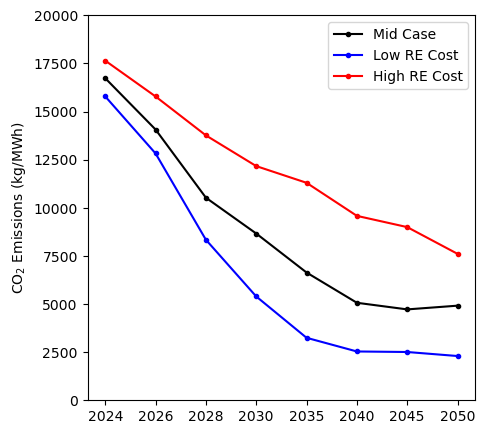

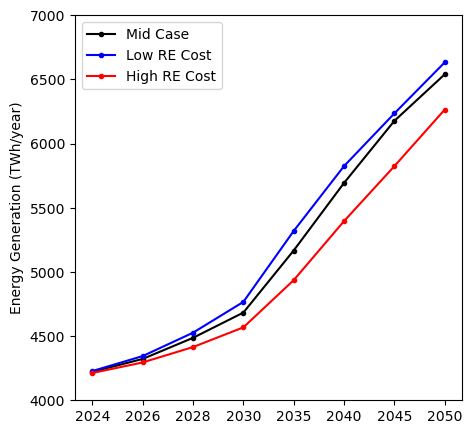

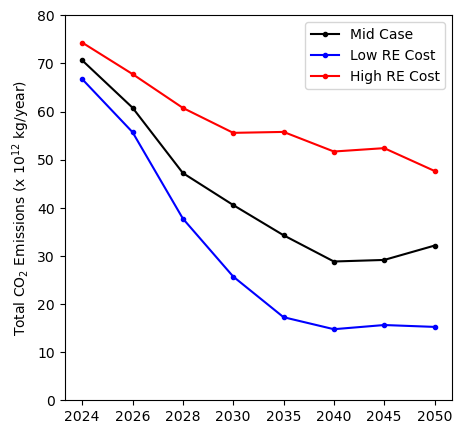

In [37]:
# CO2 time series
co2_med = np.array([16729.4,14063.7,10523.5,8662,6636.6,5065,4721,4914.9])
co2_low = np.array([15782.9,12820.9,8337.8,5392.6,3245.6,2535.4,2507.9,2298.8])
co2_high = np.array([17642.1,15781.3,13760.1,12164.5,11297.4,9579.8,8996,7606.9])

energy_med = np.array([4221938044,4322373955,4486559582,4683397835,5167093683,5693269588,6176867397,6539498283])/1e6
energy_low = np.array([4227812246,4344577215,4526694753,4766627035,5319175632,5824534599,6234946338,6632542815])/1e6
energy_high = np.array([4212678889,4294923377,4414762834,4568146287,4935918585,5395784671,5823808602,6264496482])/1e6

fig,ax= plt.subplots(figsize = (5,5))
x = [0,1,2,3,4,5,6,7]
yrs = ['', '2024','2026','2028','2030','2035','2040','2045','2050']
ax.plot(x,co2_med,label = 'Mid Case',marker ='.',color='black')
ax.plot(x,co2_low,label = 'Low RE Cost',marker ='.',color='blue')
ax.plot(x,co2_high,label = 'High RE Cost',marker ='.',color='red')
ax.set_xticklabels(yrs)
ax.set_ylim([0,20000])
ax.set_ylabel(r'CO$_{2}$ Emissions (kg/MWh)')
ax.legend()


fig,ax1= plt.subplots(figsize = (5,5))
x = [0,1,2,3,4,5,6,7]
yrs = ['', '2024','2026','2028','2030','2035','2040','2045','2050']
ax1.plot(x,energy_med,label = 'Mid Case',marker ='.',color='black')
ax1.plot(x,energy_low,label = 'Low RE Cost',marker ='.',color='blue')
ax1.plot(x,energy_high,label = 'High RE Cost',marker ='.',color='red')
ax1.set_xticklabels(yrs)
ax1.set_ylim([4000,7000])
ax1.set_ylabel(r'Energy Generation (TWh/year)')
ax1.legend()

total_co2_med =co2_med*energy_med/1e6
total_co2_low = co2_low*energy_low/1e6
total_co2_high = co2_high*energy_high/1e6

fig,ax2= plt.subplots(figsize = (5,5))
x = [0,1,2,3,4,5,6,7]
yrs = ['', '2024','2026','2028','2030','2035','2040','2045','2050']
ax2.plot(x,total_co2_med,label = 'Mid Case',marker ='.',color='black')
ax2.plot(x,total_co2_low,label = 'Low RE Cost',marker ='.',color='blue')
ax2.plot(x,total_co2_high,label = 'High RE Cost',marker ='.',color='red')
ax2.set_xticklabels(yrs)
ax2.set_ylim([0,80])
ax2.set_ylabel(r'Total CO$_{2}$ Emissions (x 10$^{12}$ kg/year)')
ax2.legend()

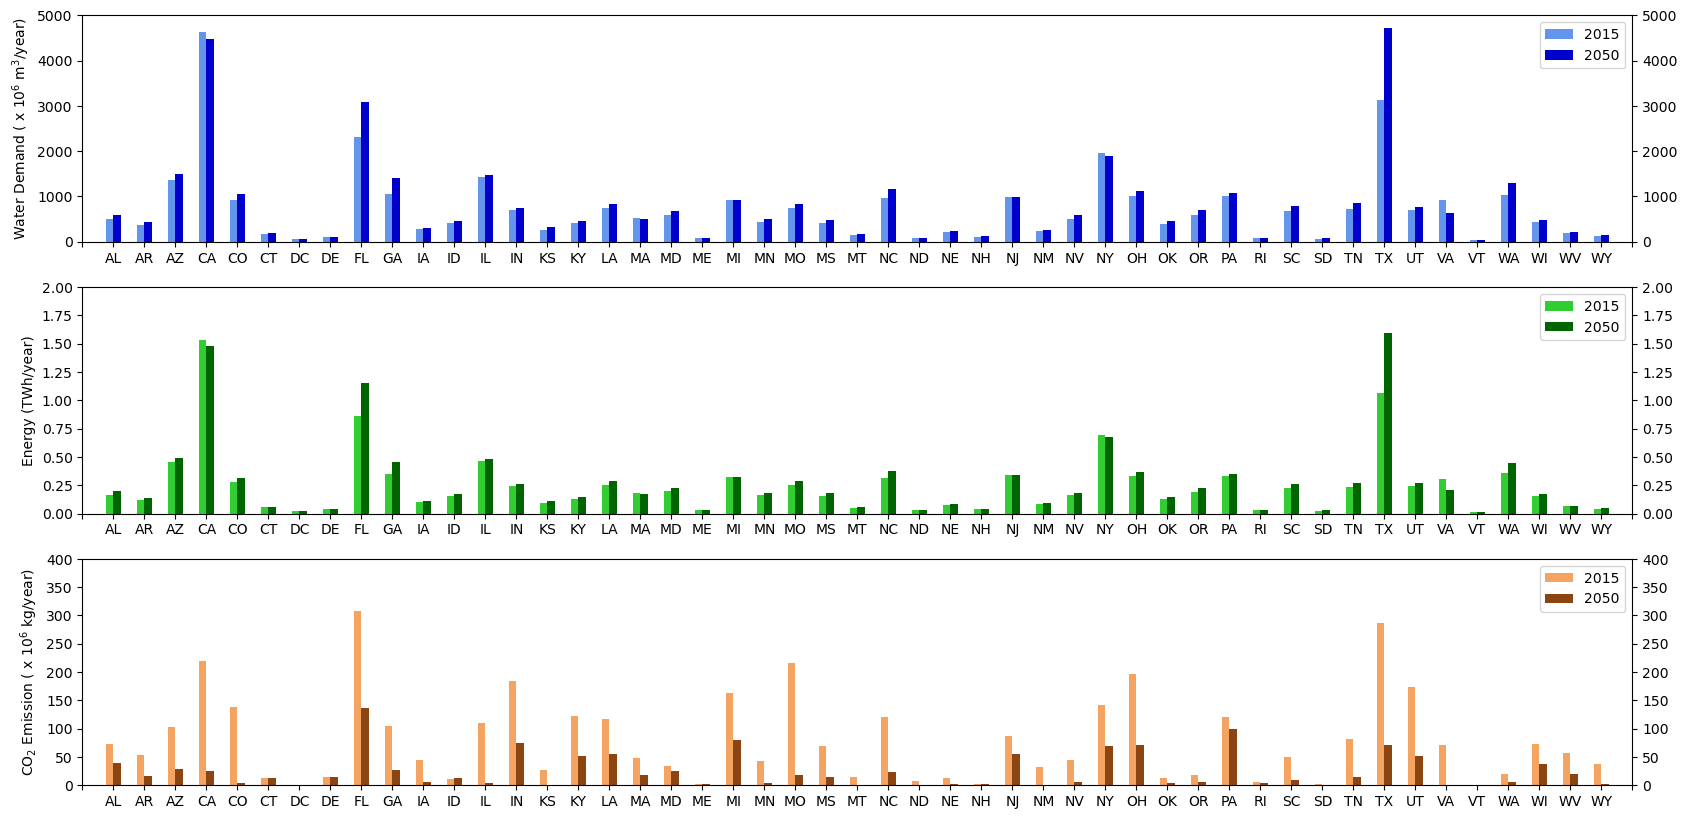

In [64]:
# Summary comparison bar plots on state basis
state_2050 = state_summary_2050.sort_values(['state'])
state_2020 = state_summary_2020.sort_values(['state'])

fig, (ax,ax1,ax2) = plt.subplots(3,1,figsize=(20,10))

x = np.array(range(0,len(state_summary_2020['state'])))*2

# Water Demand
ax.bar(x-0.25,state_2020['demand(m3/yr)']/1e6,width=0.5,label = '2015',color = 'cornflowerblue')
ax.bar(x+0.25,state_2050['demand(m3/yr)']/1e6,width=0.5,label = '2050', color = 'mediumblue')
ax.set_ylabel(r'Water Demand ( x 10$^{6}$ m$^{3}$/year)')
ax.set_ylim([0,5000])
ax.legend()

# Energy
ax1.bar(x-0.25,state_2020['energy(mwh/year)']/1e6,width=0.5,label = '2015',color = 'limegreen')
ax1.bar(x+0.25,state_2050['energy(mwh/year)']/1e6,width=0.5,label = '2050', color = 'darkgreen')
ax1.set_ylabel(r'Energy (TWh/year)')
ax1.set_ylim([0,2])
ax1.legend()

# CO2 emissions
ax2.bar(x-0.25,state_2020['co2(kg/year)']/1e6,width=0.5,label = '2015',color = 'sandybrown')
ax2.bar(x+0.25,state_2050['co2(kg/year)']/1e6,width=0.5,label = '2050', color = 'saddlebrown')
ax2.set_ylabel(r'CO$_{2}$ Emission ( x 10$^{6}$ kg/year)')
ax2.set_ylim([0,400])
ax2.legend()

ticklabels = np.concatenate(([' '],state_2020['state'],[' ']))

for a in ax,ax1,ax2:
    a.set_xticklabels(ticklabels)
    a.set_xlim([-2,98])
    a.xaxis.set_major_locator(plt.MaxNLocator(len(state_2020['state'])+1))
    a.yaxis.set_ticks_position('both')
    a.tick_params(labelleft=True, labelright=True)



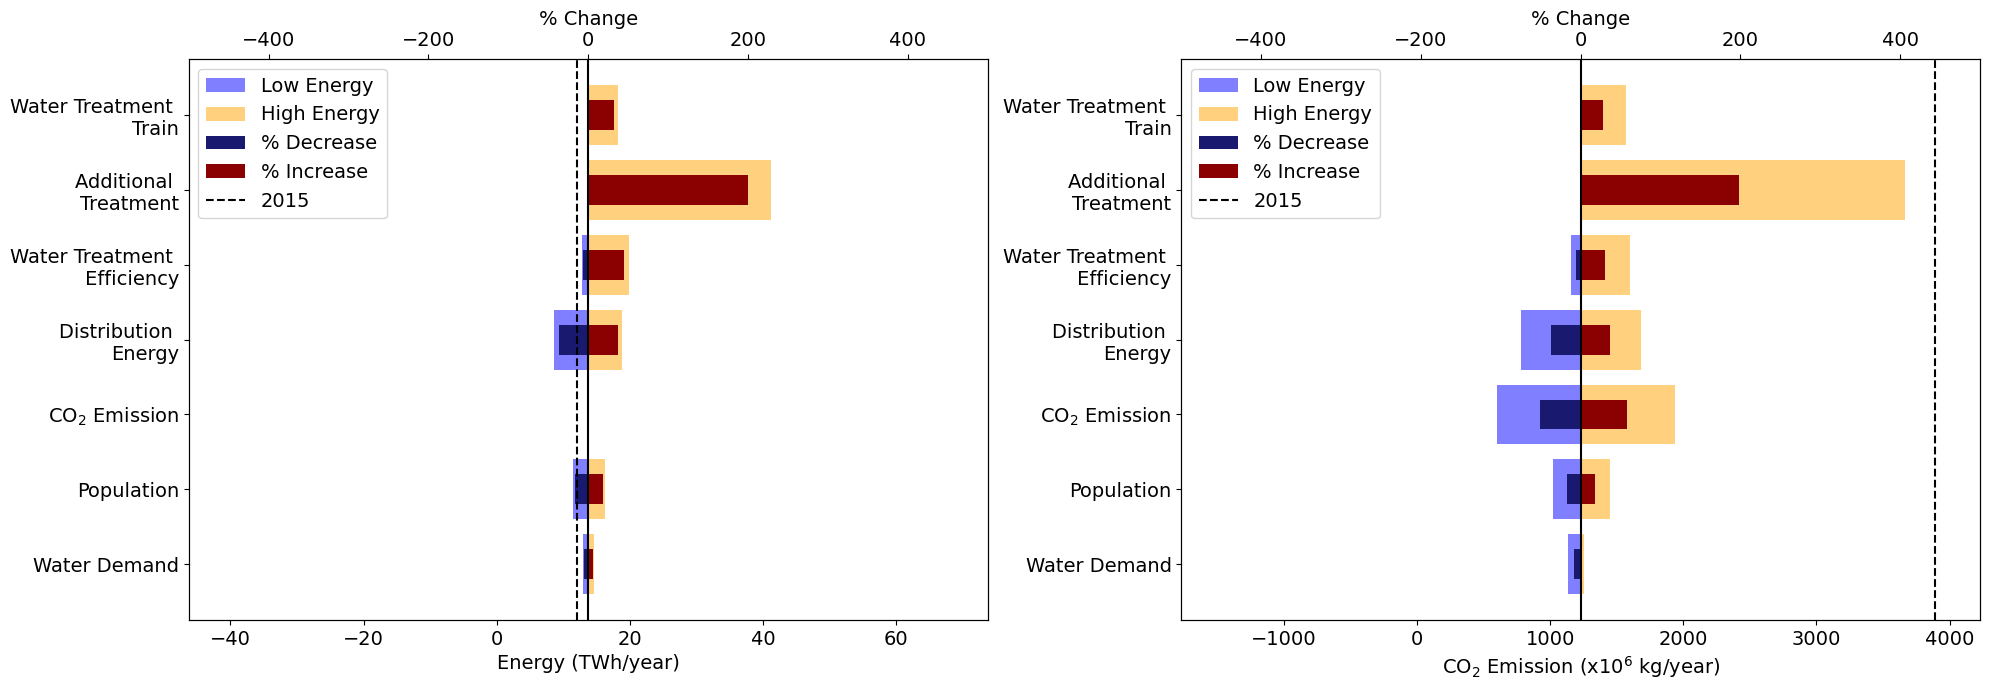

In [39]:
# Sensitivity tornado plot

# Reading sensitivity data
df = pd.read_excel(r'\Users\mhardika\Documents\AMO\2050\analysis_files\sensitivity_analysis.xlsx')
# df.head()

fig,(ax0,ax1) = plt.subplots(1,2,figsize = (20,7))
ax0.barh(y=df['parameter'],width = df['energy_mean(twh/yr)']-df['energy_low'],left=df['energy_low'],color='blue',label = 'Low Energy',alpha=0.5)
ax0.barh(y=df['parameter'],width = df['energy_high']-df['energy_mean(twh/yr)'],left = df['energy_mean(twh/yr)'], color='orange',label = 'High Energy',alpha=0.5)

ax01 = ax0.twiny()
ax01.barh(y=df['parameter'],width = df['energy_percent_decrease']*100,left=-df['energy_percent_decrease']*100,color='midnightblue',label = '% Decrease',height=0.4)
ax01.barh(y=df['parameter'],width = df['energy_percent_increase']*100, color='darkred',label = '% Increase',height=0.4)

ax0.set_xlim([df['energy_mean(twh/yr)'][0]-60,df['energy_mean(twh/yr)'][0]+60])
ax01.set_xlim([-500,500])

ax02 = ax0.twinx()
ax02.axvline(x=13.727, color = 'black')
ax02.axvline(x=12.12, color = 'black', ls ='--',label='2015')

ax0.set_yticklabels(['Water Demand', 'Population', r'CO$_{2}$ Emission','Distribution \nEnergy','Water Treatment \n Efficiency',
                'Additional \nTreatment', 'Water Treatment \nTrain'], fontsize = 14)
ax0.set_xlabel('Energy (TWh/year)',fontsize=14)
ax01.set_xlabel('% Change',fontsize=14)
ax02.axis('off')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax0.get_legend_handles_labels()
lines1, labels1 = ax01.get_legend_handles_labels()
lines2, labels2 = ax02.get_legend_handles_labels()
ax0.legend(lines + lines1+ lines2, labels + labels1 + labels2, loc='upper left',fontsize = 14)

# CO2 Plot
ax1.barh(y=df['parameter'],width = df['co2_mean(1e6kg/yr)']-df['co2_low'],left=df['co2_low'],color='blue',label = 'Low Energy',alpha=0.5)
ax1.barh(y=df['parameter'],width = df['co2_high']-df['co2_mean(1e6kg/yr)'],left = df['co2_mean(1e6kg/yr)'], color='orange',label = 'High Energy',alpha=0.5)

ax11 = ax1.twiny()

ax11.barh(y=df['parameter'],width = df['co2_percent_decrease']*100,left=-df['co2_percent_decrease']*100,color='midnightblue',label = '% Decrease',height=0.4)
ax11.barh(y=df['parameter'],width = df['co2_percent_increase']*100, color='darkred',label = '% Increase',height=0.4)

ax1.set_xlim([df['co2_mean(1e6kg/yr)'][0]-3000,df['co2_mean(1e6kg/yr)'][0]+3000])
ax11.set_xlim([-500,500])

ax12 = ax1.twinx()
ax12.axvline(x=1228.18, color = 'black')
ax12.axvline(x=3893, color = 'black', ls ='--',label='2015')
ax12.axis('off')

ax1.set_yticklabels(['Water Demand', 'Population', r'CO$_{2}$ Emission','Distribution \nEnergy','Water Treatment \n Efficiency',
                'Additional \nTreatment', 'Water Treatment \nTrain'], fontsize = 14)

ax1.set_xlabel(r'CO$_{2}$ Emission (x10$^{6}$ kg/year)',fontsize=14)
ax11.set_xlabel('% Change',fontsize=14)


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines1, labels1 = ax11.get_legend_handles_labels()
lines2, labels2 = ax12.get_legend_handles_labels()
ax1.legend(lines + lines1+ lines2, labels + labels1 + labels2, loc='upper left',fontsize = 14)


for ax in ax0,ax01,ax1,ax11:
    ax.tick_params(axis='x', labelsize=14)

ax01.set_xlabel('% Change',fontsize=14)
ax11.set_xlabel('% Change',fontsize=14)

fig.tight_layout()

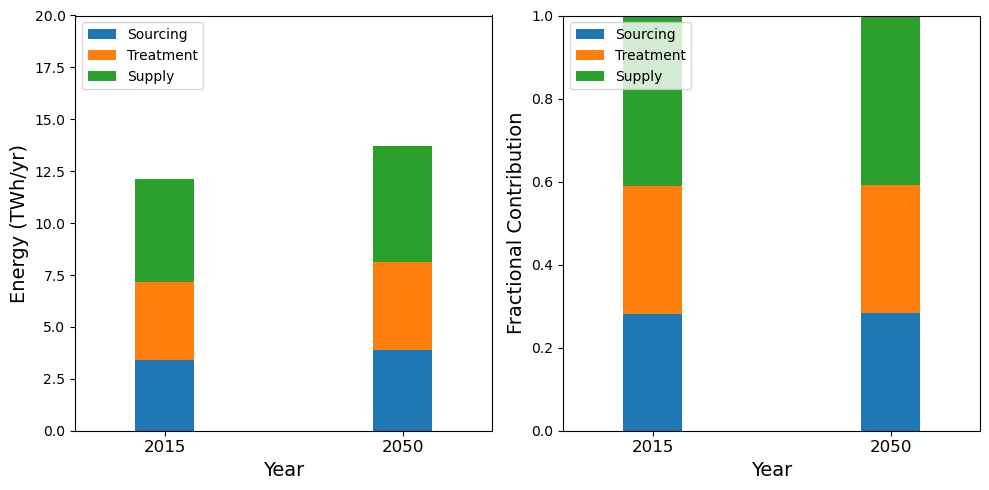

In [40]:
# Stacked bar plot showing contribution of treatment, pumping, distribution energy for 2015 and 2050
cols = ['2015_pumping(mwh/yr)','2015_treatment(mwh/yr)','2015_dist(mwh/yr)','2050_pumping(mwh/yr)','2050_treatment(mwh/yr)','2050_dist(mwh/yr)']

stacked_bar_national = pd.DataFrame(columns = cols)

stacked_bar_national['2015_pumping(mwh/yr)'] = analysis_results_2020['pumping_energy(kwh/m3)']*analysis_results_2020['county_demand_2015(m3/day)']*365.25/1000
stacked_bar_national['2050_pumping(mwh/yr)'] = analysis_results_2050['pumping_energy(kwh/m3)']*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000

stacked_bar_national['2015_treatment(mwh/yr)'] = analysis_results_2020['treatment_energy(kwh/m3)']*analysis_results_2020['county_demand_2015(m3/day)']*365.25/1000
stacked_bar_national['2050_treatment(mwh/yr)'] = analysis_results_2050['treatment_energy(kwh/m3)']*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000

stacked_bar_national['2015_dist(mwh/yr)'] = analysis_results_2020['dist_energy(kwh/m3)']*analysis_results_2020['county_demand_2015(m3/day)']*365.25/1000
stacked_bar_national['2050_dist(mwh/yr)'] = analysis_results_2050['dist_energy(kwh/m3)']*analysis_results_2050['county_demand_2050(m3/day)']*365.25/1000


# ax = stacked_bar_national['treatment_energy(kwh/m3)','pumping_energy(kwh/m3)','dist_energy(kwh/m3)']
case = ['2015','2050']
pumping = [stacked_bar_national['2015_pumping(mwh/yr)'].sum()/analysis_results_2020['total_energy(mwh/year)'].sum() ,stacked_bar_national['2050_pumping(mwh/yr)'].sum()/analysis_results_2050['total_energy(mwh/year)'].sum() ]
treatment = [stacked_bar_national['2015_treatment(mwh/yr)'].sum()/analysis_results_2020['total_energy(mwh/year)'].sum() , stacked_bar_national['2050_treatment(mwh/yr)'].sum()/analysis_results_2050['total_energy(mwh/year)'].sum() ]
dist = [stacked_bar_national['2015_dist(mwh/yr)'].sum()/analysis_results_2020['total_energy(mwh/year)'].sum() ,stacked_bar_national['2050_dist(mwh/yr)'].sum()/analysis_results_2050['total_energy(mwh/year)'].sum() ]

case = ['2015','2050']
pumping_1 = [stacked_bar_national['2015_pumping(mwh/yr)'].sum()/1e6,stacked_bar_national['2050_pumping(mwh/yr)'].sum()/1e6]
treatment_1 = [stacked_bar_national['2015_treatment(mwh/yr)'].sum()/1e6, stacked_bar_national['2050_treatment(mwh/yr)'].sum()/1e6]
dist_1 = [stacked_bar_national['2015_dist(mwh/yr)'].sum() /1e6,stacked_bar_national['2050_dist(mwh/yr)'].sum()/1e6 ]

stacked_bar_national_plot = pd.DataFrame(zip(case, pumping,treatment,dist),columns=['Case','Sourcing','Treatment','Supply'])
stacked_bar_national_plot_1 = pd.DataFrame(zip(case, pumping_1,treatment_1,dist_1),columns=['Case','Sourcing','Treatment','Supply'])

fig, (ax1,ax) = plt.subplots(1,2, figsize = (10,5))
my_cmap = plt.get_cmap("viridis")
stacked_bar_national_plot[['Case','Sourcing','Treatment','Supply']].plot.bar(ax= ax, x='Case',stacked=True,width=0.25)
stacked_bar_national_plot_1[['Case','Sourcing','Treatment','Supply']].plot.bar(ax= ax1, x='Case',stacked=True, width=0.25)

ax.set_xticklabels(['2015', '2050'], rotation=0,fontsize = 12)
ax.set_ylim([0,1])
ax.set_ylabel('Fractional Contribution',fontsize = 14)
ax.set_xlabel('Year',fontsize = 14)
ax.legend(loc='upper left')

ax1.set_xticklabels(['2015', '2050'], rotation=0,fontsize = 12)
ax1.set_ylim([0,20])
ax1.set_ylabel('Energy (TWh/yr)',fontsize = 14)
ax1.set_xlabel('Year',fontsize = 14)
ax1.legend(loc='upper left')
fig.tight_layout()


In [66]:
# Dataframe to plot water demand at state level
state_2050 = state_summary_2050.sort_values(['state'])
state_2020 = state_summary_2020.sort_values(['state'])

state_energy_gen = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_energy_generation.csv')

us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]
us_states_cont = us_states_cont.set_index('STUSPS')

geometry_col=[]

for state in state_2020['state'].unique():
    geometry_col.append(us_states_cont.loc[state]['geometry'])

state_2020['geometry'] = geometry_col

total_energy_2015 = state_energy_gen['2015(mwh)'].sum() # 3758992390 # MWh
energy_frac_col = state_2020['energy(mwh/year)']/total_energy_2015*100
energy_frac_state = state_2020['energy(mwh/year)']/state_energy_gen['2015(mwh)']*100

state_2020['energy_frac'] = energy_frac_col
state_2020['energy_frac_state'] = energy_frac_state

diff_col = []
geometry_col=[]
for state in state_2050['state'].unique():
    geometry_col.append(us_states_cont.loc[state]['geometry'])

total_energy_2050 = state_energy_gen['2050(mwh)'].sum() #6539498283 # MWh
energy_frac_col = state_2050['energy(mwh/year)']/total_energy_2050*100
energy_frac_state = state_2050['energy(mwh/year)']/state_energy_gen['2050(mwh)']*100

diff_col_demand = 100*(state_2050['demand(m3/yr)'] - state_2020['demand(m3/yr)'])/state_2020['demand(m3/yr)']
diff_col_energy = 100*(state_2050['energy(mwh/year)'] - state_2020['energy(mwh/year)'])/state_2020['energy(mwh/year)']
diff_col_co2 = 100*(state_2050['co2(kg/year)'] - state_2020['co2(kg/year)'])/state_2020['co2(kg/year)']


state_2050['geometry'] = geometry_col
state_2050['demand%'] = diff_col_demand
state_2050['energy%'] = diff_col_energy
state_2050['co2%'] = diff_col_co2
state_2050['energy_frac']=energy_frac_col
state_2050['energy_frac_state'] = energy_frac_state

diff_energy_frac_state = 100*(state_2050['energy_frac_state']-state_2020['energy_frac_state'])/state_2020['energy_frac_state']
state_2050['%energy_frac_state'] = diff_energy_frac_state

state_2050 = state_2050.dropna()
state_2020 = state_2020.dropna()
# state_2050.head()


In [42]:
# state_2050.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_summary_2050.csv')
# state_2020.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_summary_2015.csv')

In [43]:
(0.348-0.112)/0.112*100

210.71428571428572

In [44]:
state_2020['energy(mwh/year)'].sum()/total_energy_2015*100 
state_2050['energy(mwh/year)'].sum()/total_energy_2050*100 

0.2091480389789226

In [45]:
state_2050 = state_2050.dropna()

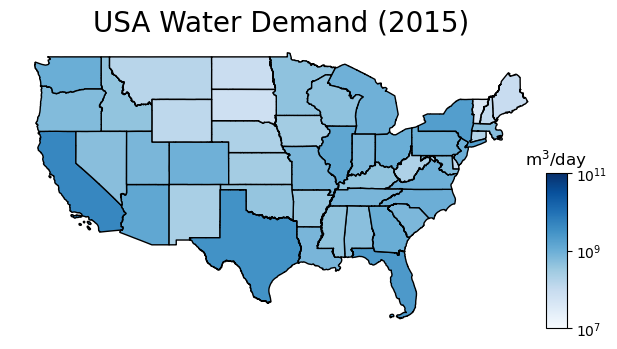

In [68]:
# State average water demand 2015
geodf = gp.GeoDataFrame(state_2020,crs="EPSG:4326", geometry=state_2020['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['demand(m3/yr)'].min(), geodf['demand(m3/yr)'].max()
colormap = "Blues"
# add color scale
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Demand (2015)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'm$^{\rm 3}$/day')
    
geodf.plot(ax = ax , column = geodf['demand(m3/yr)'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(1e7,1e11)


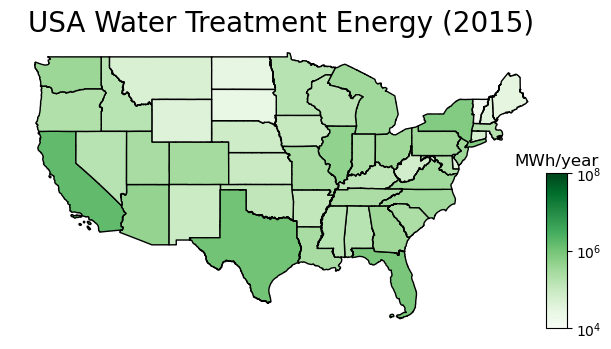

In [47]:
# State average energy 2015
geodf = gp.GeoDataFrame(state_2020,crs="EPSG:4326", geometry=state_2020['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy(mwh/year)'].min(), geodf['energy(mwh/year)'].max()
colormap = "Greens"
# add color scale
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Treatment Energy (2015)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('MWh/year')
    
geodf.plot(ax = ax , column = geodf['energy(mwh/year)'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(1e4,1e8)


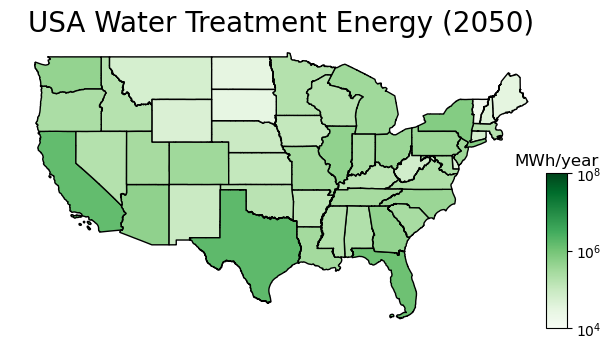

In [48]:
# State average energy 2050
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy(mwh/year)'].min(), geodf['energy(mwh/year)'].max()
colormap = "Greens"
# add color scale
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Treatment Energy (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('MWh/year')
    
geodf.plot(ax = ax , column = geodf['energy(mwh/year)'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(1e4,1e8)

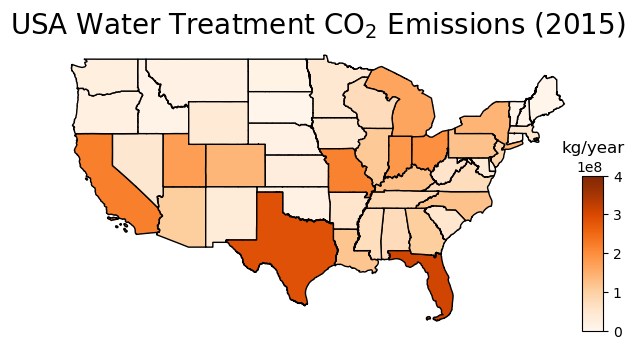

In [49]:
# State average emissions 2015
geodf = gp.GeoDataFrame(state_2020,crs="EPSG:4326", geometry=state_2020['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['co2(kg/year)'].min(), geodf['co2(kg/year)'].max()
colormap = "Oranges"
# add color scale
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Treatment CO$_{2}$ Emissions (2015)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('kg/year')
    
geodf.plot(ax = ax , column = geodf['co2(kg/year)'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,4e8)


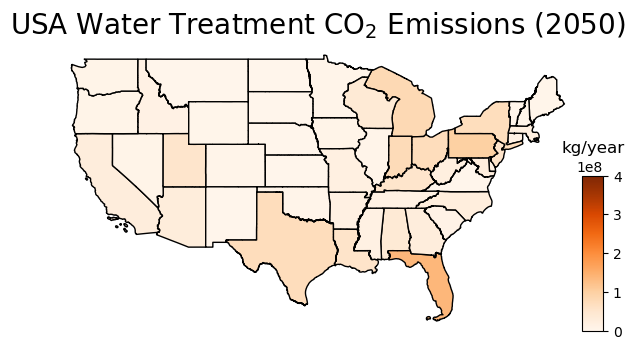

In [50]:
# State average emissions 2050
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['co2(kg/year)'].min(), geodf['co2(kg/year)'].max()
colormap = "Oranges"
# add color scale
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Treatment CO$_{2}$ Emissions (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('kg/year')
    
geodf.plot(ax = ax , column = geodf['co2(kg/year)'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,4e8)


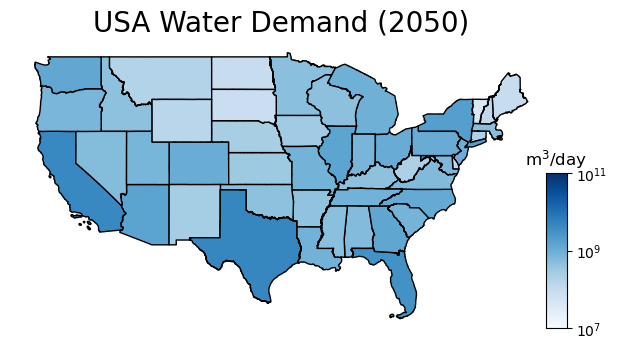

In [69]:
# State average water demand 2050
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['demand(m3/yr)'].min(), geodf['demand(m3/yr)'].max()
colormap = "Blues"
# add color scale
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('USA Water Demand (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'm$^{\rm 3}$/day')

# Plotting contiguous states one at a time
# for state in geodf_cont['state_id'].unique():
#     geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
#     geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')
    
geodf.plot(ax = ax , column = geodf['demand(m3/yr)'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(1e7,1e11)

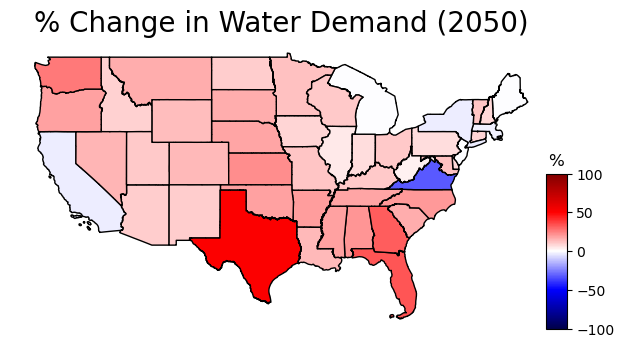

In [52]:
# State average water demand
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['demand%'].min(), geodf['demand%'].max()
colormap = "seismic"
# add color scale
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm = norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% Change in Water Demand (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')

# Plotting contiguous states one at a time
# for state in geodf_cont['state_id'].unique():
#     geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
#     geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')
    
geodf.plot(ax = ax , column = geodf['demand%'], edgecolor='black',cmap=colormap, norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(-100,100)

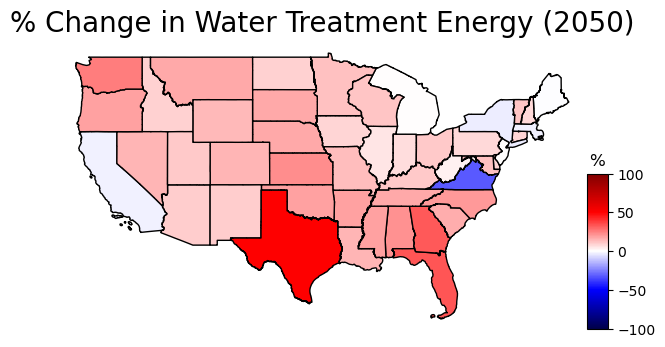

In [53]:
# State average water demand
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy%'].min(), geodf['energy%'].max()
colormap = "seismic"
# add color scale'
norm = norm=plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% Change in Water Treatment Energy (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['energy%'], edgecolor='black',cmap=colormap,norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(-100,100)

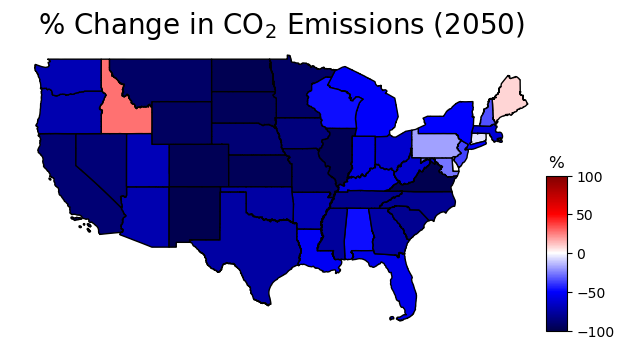

In [54]:
# State average water demand
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

geodf = geodf[geodf['state']!='VT']

# Creating scale for colorbar
vmin,vmax = geodf['co2%'].min(), sorted(geodf['co2%'])[-2]
colormap = "seismic"
# add color scale
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title(r'% Change in CO$_{2}$ Emissions (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['co2%'], edgecolor='black',cmap=colormap, norm=norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(-100,100)

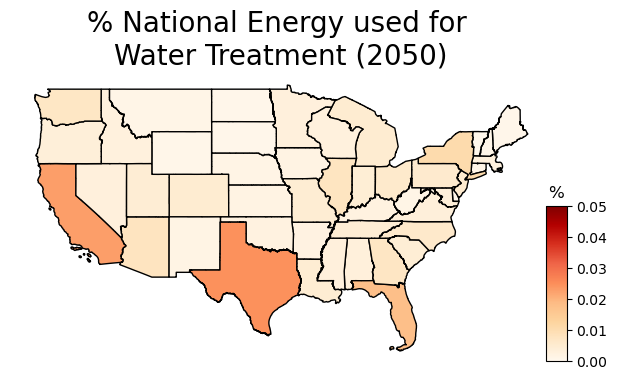

In [55]:
# Energy as a fraction of national energy
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy_frac'].min(), geodf['energy_frac'].max()
colormap = "OrRd"
# add color scale
norm= plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm= norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% National Energy used for \nWater Treatment (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['energy_frac'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,0.05)

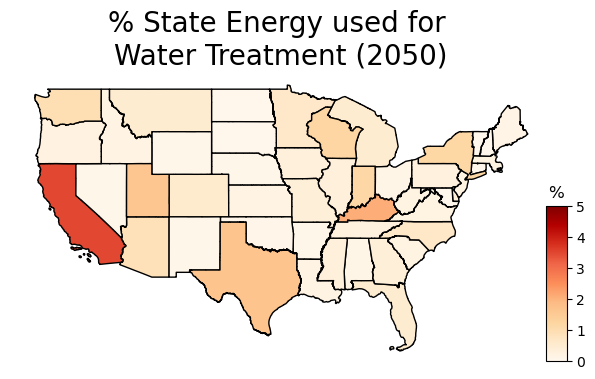

In [56]:
# Energy as a fraction of state energy
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy_frac_state'].min(), geodf['energy_frac_state'].max()
colormap = "OrRd"
# add color scale
norm= plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm= norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% State Energy used for \nWater Treatment (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['energy_frac_state'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,5)

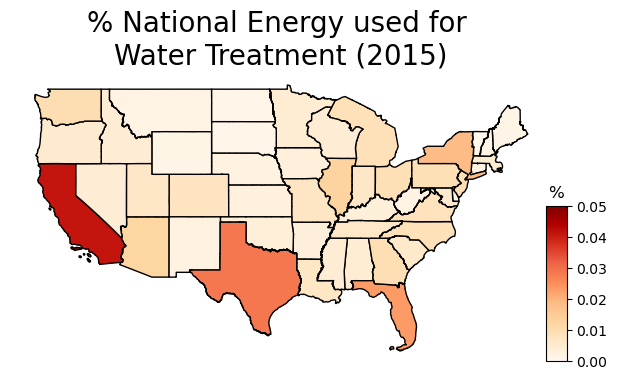

In [57]:
# Energy as a fraction of national energy
geodf = gp.GeoDataFrame(state_2020,crs="EPSG:4326", geometry=state_2020['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy_frac'].min(), geodf['energy_frac'].max()
colormap = "OrRd"
# add color scale
norm= plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm= norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% National Energy used for \nWater Treatment (2015)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['energy_frac'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,0.05)

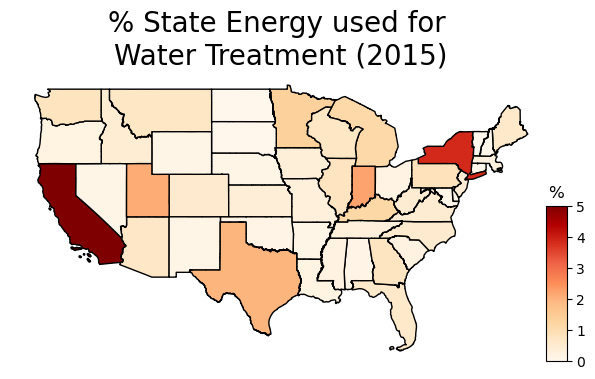

In [58]:
# Energy as a fraction of state energy
geodf = gp.GeoDataFrame(state_2020,crs="EPSG:4326", geometry=state_2020['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['energy_frac_state'].min(), geodf['energy_frac_state'].max()
colormap = "OrRd"
# add color scale
norm= plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm= norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% State Energy used for \nWater Treatment (2015)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['energy_frac_state'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,5)

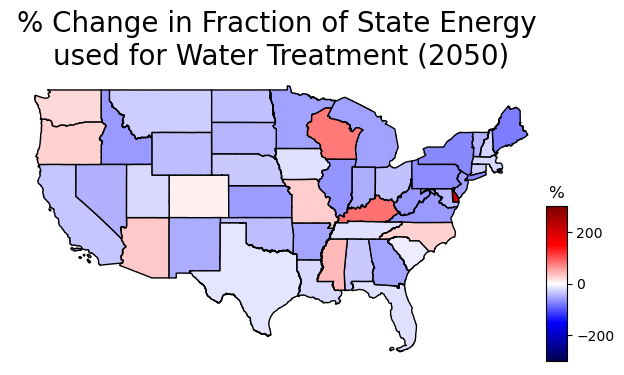

In [59]:
# % Change in energy as a fraction of state energy
geodf = gp.GeoDataFrame(state_2050,crs="EPSG:4326", geometry=state_2050['geometry'])

# Creating scale for colorbar
vmin,vmax = geodf['%energy_frac_state'].min(), geodf['%energy_frac_state'].max()
colormap = "seismic"
# add color scale
norm= plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap , norm= norm)

# Create figure
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')

# Set title
ax.set_title('% Change in Fraction of State Energy \nused for Water Treatment (2050)',fontdict={'fontsize': '20', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'%')
    
geodf.plot(ax = ax , column = geodf['%energy_frac_state'], edgecolor='black',cmap=colormap,norm = norm)
fig.colorbar(sm, cax=cbax)
sm.set_clim(-300,300)

In [60]:
# Dataframe to plot water demand
us_counties_temp = us_counties.set_index('GEOID')
geometry_col = []
idx_list = []
for idx , row in demand_present_df.iterrows():
    geoid = str("{:05d}".format(row['geoid']))
    try:
        geometry_col.append(us_counties_temp.loc[geoid].geometry)
    except KeyError:
        pass
        idx_list.append(idx)
    except IndexError:
        pass
    except ValueError:
        pass

demand_present_loc = demand_present_df.drop(index=idx_list)
demand_present_loc['geometry'] = geometry_col
demand_present_loc.head(3)


us_counties_temp = us_counties.set_index('GEOID')
# Calculating % change in demand
geometry_col = []
diff_col = []
idx_list = []
for idx , row in demand_projection_df.iterrows():
    geoid = str("{:05d}".format(int(row['geoid'])))
    try:
        geometry_col.append(us_counties_temp.loc[geoid].geometry)
        diff = (100*(row['2050_med_domestic_supply_total(m3/day)']-demand_present_loc[demand_present_loc['geoid']==int(geoid)]['2015_domestic_supply_total(m3/day)'].values[0])
                /demand_present_loc[demand_present_loc['geoid']==int(geoid)]['2015_domestic_supply_total(m3/day)'].values[0])
        diff_col.append(diff)
    except KeyError:
        pass
        idx_list.append(idx)
    except IndexError:
        pass
    except ValueError:
        pass

demand_projection_loc = demand_projection_df.drop(index=idx_list)
demand_projection_loc['geometry'] = geometry_col
demand_projection_loc['difference %'] = diff_col

# demand_projection_loc.head(3)

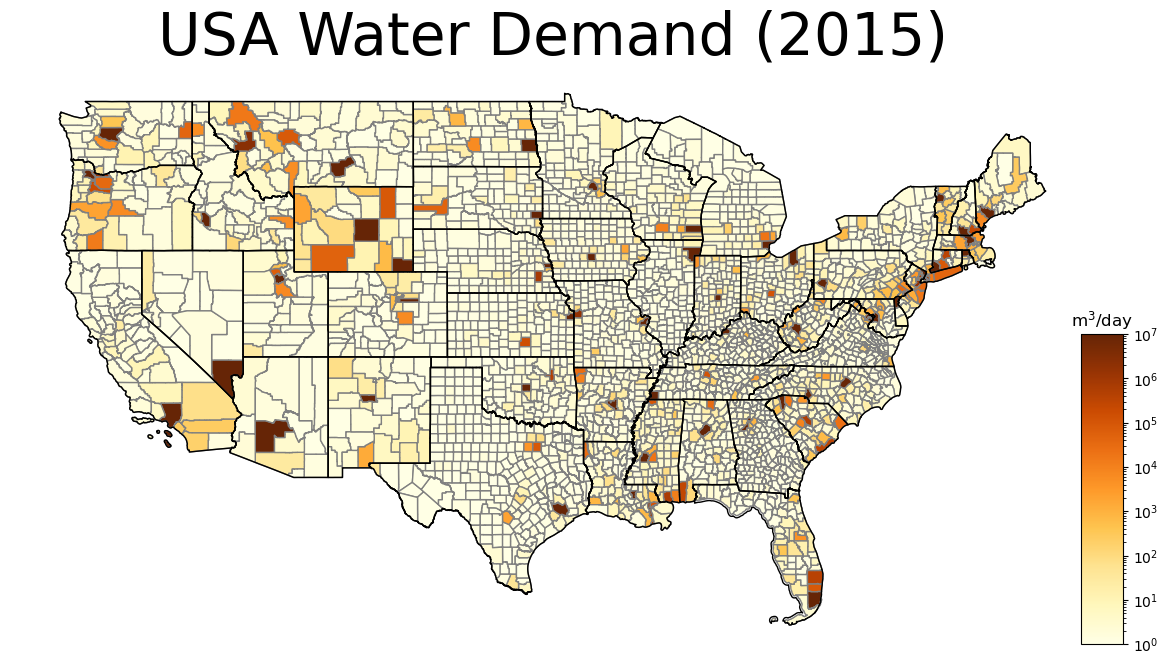

In [61]:
# Plot water demand USA with Alaska and Hawaii for 2015

geodf = gp.GeoDataFrame(demand_present_loc,crs="EPSG:4326", geometry=demand_present_loc['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['2015_domestic_supply_total(m3/day)'].min(), geodf['2015_domestic_supply_total(m3/day)'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title('USA Water Demand (2015)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'm$^{\rm 3}$/day')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(1,1e7)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

KeyboardInterrupt: 

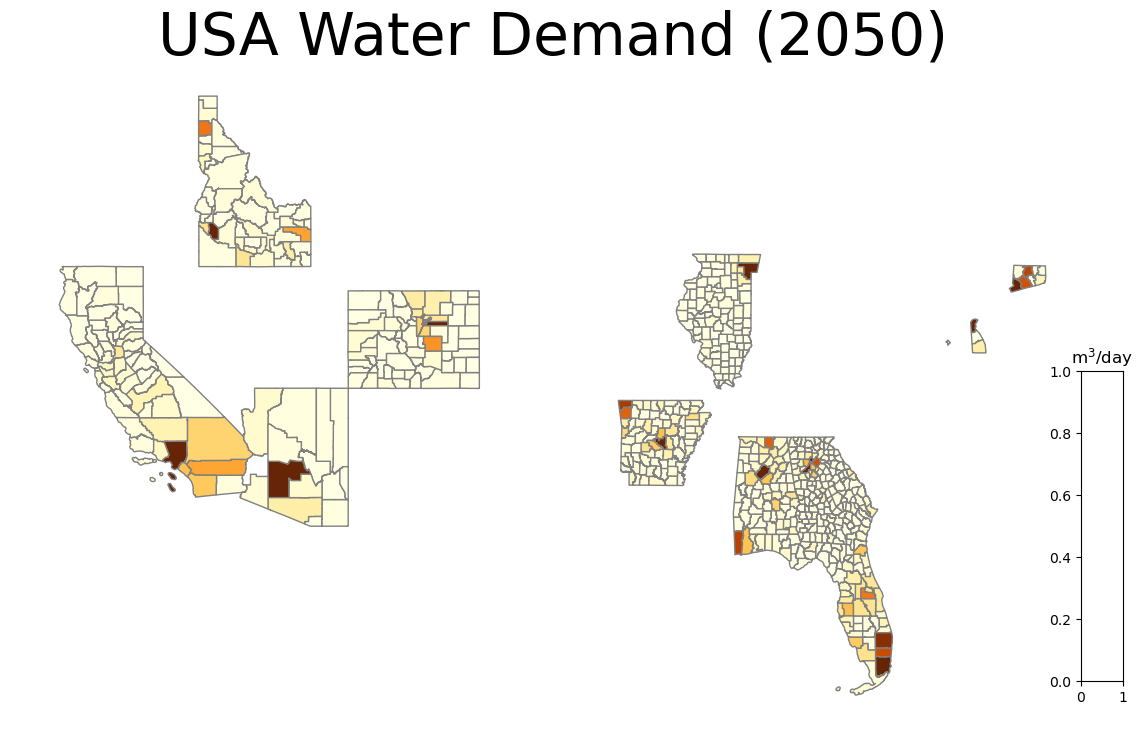

In [62]:
# Plot water demand USA without Alaska and Hawaii for 2050

geodf = gp.GeoDataFrame(demand_projection_loc,crs="EPSG:4326", geometry=demand_projection_loc['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['2050_med_domestic_supply_total(m3/day)'].min(), geodf['2050_med_domestic_supply_total(m3/day)'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title('USA Water Demand (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title(r'm$^{\rm 3}$/day')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['2050_med_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(1,1e7)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['2050_med_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['2050_med_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

KeyboardInterrupt: 

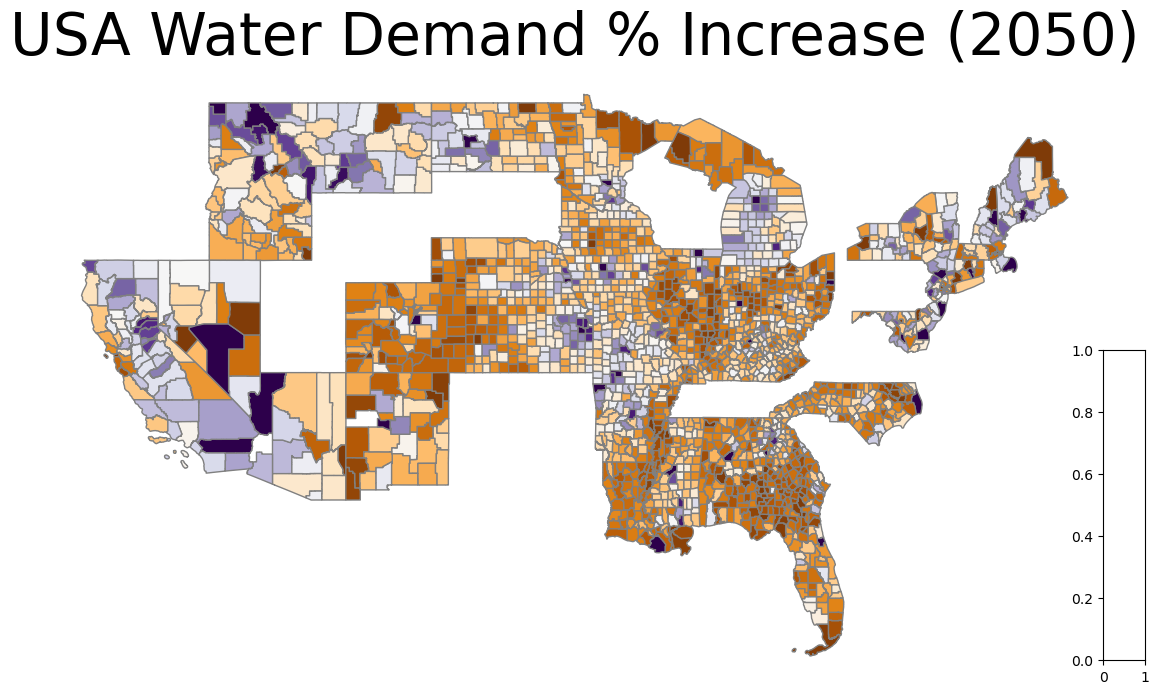

In [ ]:
# Plot % increase water demand USA with Alaska and Hawaii in 2050

geodf = gp.GeoDataFrame(demand_projection_loc,crs="EPSG:4326", geometry=demand_projection_loc['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['difference %'].min(), geodf['difference %'].max()
colormap = "PuOr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title('USA Water Demand % Increase (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
# cbax.set_title(r'm$^{\rm 3}$/day')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['difference %'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(-150,150)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['2050_med_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['2050_med_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

In [ ]:
# Dataframe to plot energy
# us_counties_temp = us_counties.set_index('GEOID')
geoid_col = []
energy_2020 = []
energy_2050 = []
diff_col = []
geometry_col=[]
state_id_col = []

idx_list = []
for idx , row in analysis_results_2050.iterrows():
    geoid = str("{:05d}".format(int(row['geoid'])))
    try:
        energy_2050.append(row['total_energy(mwh/year)'])
        energy_2020.append(analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['total_energy(mwh/year)'].values[0])
        geoid_col.append(int(geoid))
        geometry_col.append(row['geometry'])

        diff = (100*(row['total_energy(mwh/year)']-analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['total_energy(mwh/year)'].values[0])
                /analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['total_energy(mwh/year)'].values[0])
        diff_col.append(diff)
        state_id_col.append(int(row['state_id']))
    except KeyError:
        pass
        # idx_list.append(idx)
    except IndexError:
        pass
    except ValueError:
        pass


energy_plot_df = pd.DataFrame(zip(state_id_col, geoid_col,energy_2020,energy_2050,diff_col, geometry_col), 
                                columns=['state_id','geoid','energy_2015',"energy_2050", 'difference %', 'geometry'])

# energy_plot_df['state_id']

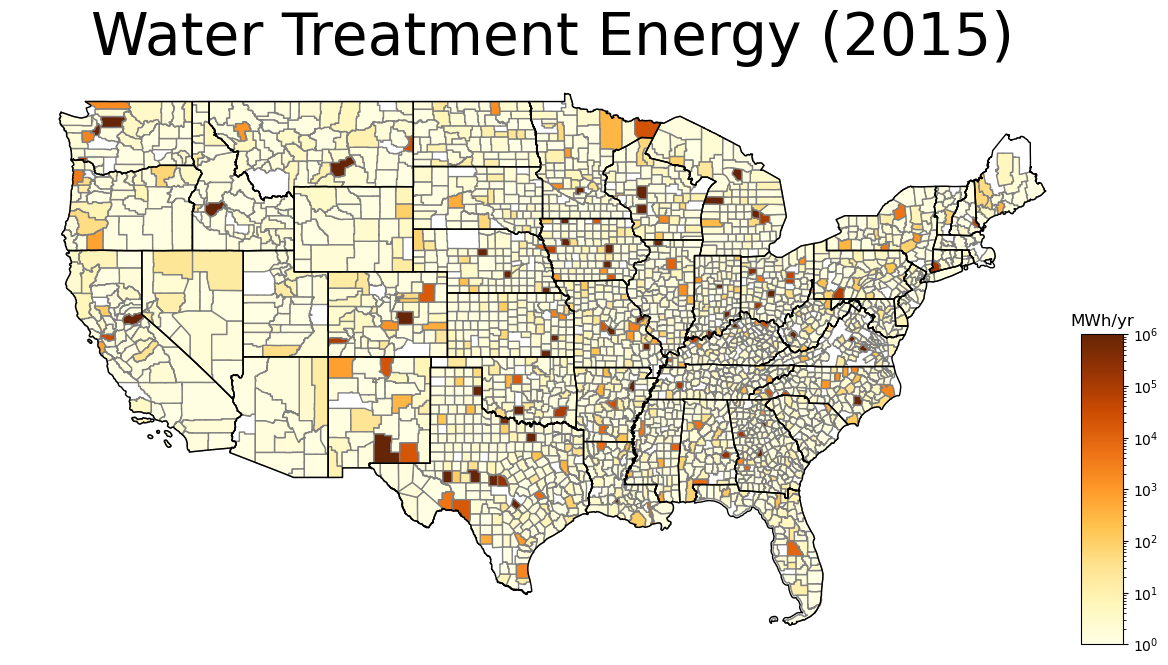

In [ ]:
# Plot energy for 2015

# Plot water demand USA with Alaska and Hawaii for 2015

geodf = gp.GeoDataFrame(energy_plot_df,crs="EPSG:4326", geometry=energy_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['energy_2015'].min(), geodf['energy_2015'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')


# Set title
ax.set_title('Water Treatment Energy (2015)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('MWh/yr')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['energy_2015'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(1,1e6)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['energy_2015'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['energy_2015'],cmap=colormap,edgecolor='grey')


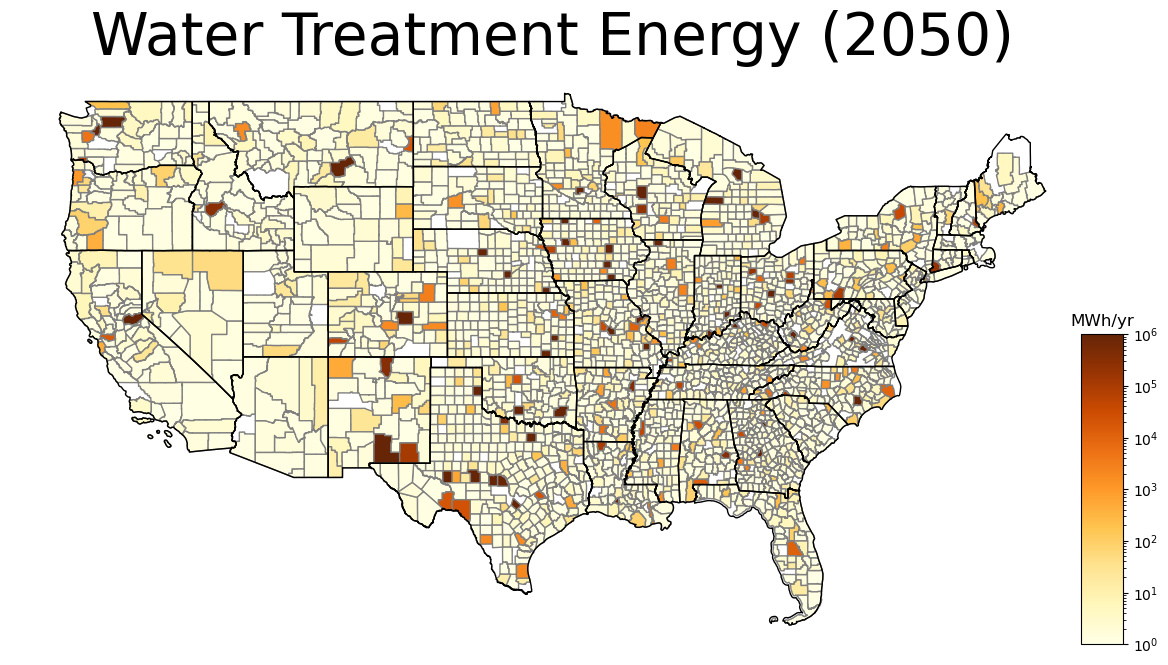

In [ ]:
# Plot energy for 2050

# Plot water demand USA with Alaska and Hawaii for 2015

geodf = gp.GeoDataFrame(energy_plot_df,crs="EPSG:4326", geometry=energy_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['energy_2050'].min(), geodf['energy_2050'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title('Water Treatment Energy (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('MWh/yr')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['energy_2050'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(1,1e6)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['energy_2050'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['energy_2050'],cmap=colormap,edgecolor='grey')


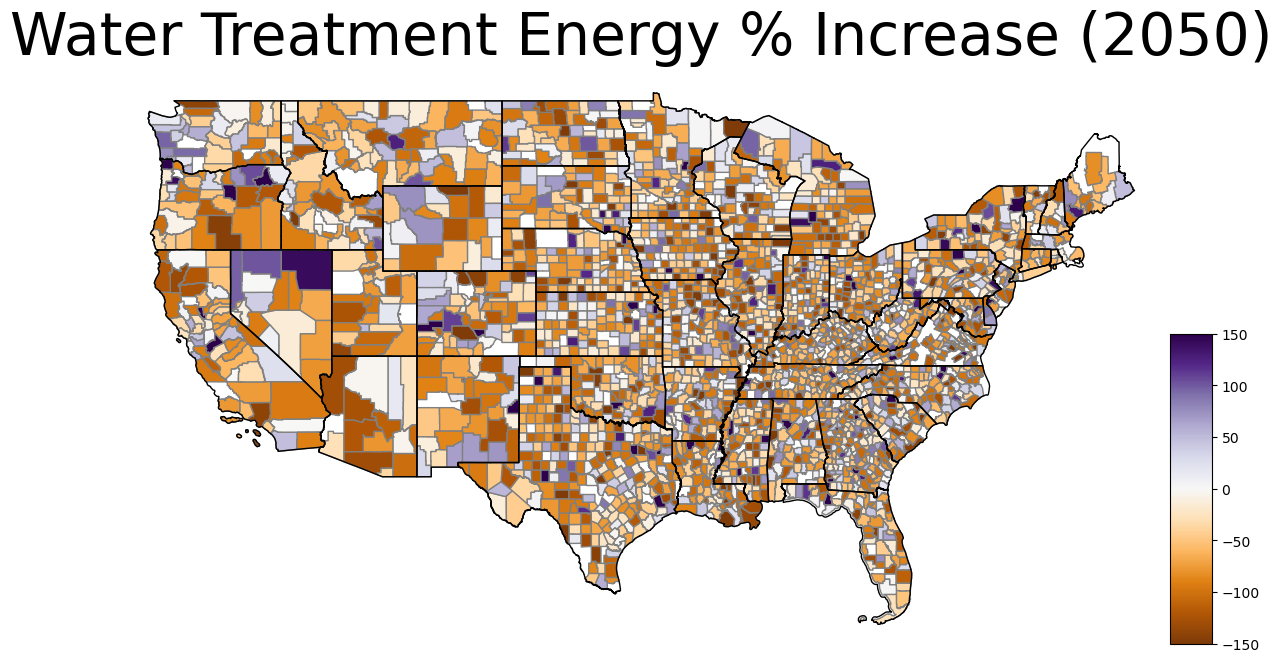

In [ ]:
# Plot % increase in energy for 2050

geodf = gp.GeoDataFrame(energy_plot_df,crs="EPSG:4326", geometry=energy_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['difference %'].min(), geodf['difference %'].max()
colormap = "PuOr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')


# Set title
ax.set_title('Water Treatment Energy % Increase (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['difference %'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(-150,150)
# sm.set_clim(1,1e6)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['difference %'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['difference %'],cmap=colormap,edgecolor='grey')


In [ ]:
# Dataframe to plot CO2 emission
# us_counties_temp = us_counties.set_index('GEOID')
geoid_col = []
emissions_2024 = []
emissions_2050 = []
diff_col = []
geometry_col=[]
state_id_col = []

idx_list = []
for idx , row in analysis_results_2050.iterrows():
    geoid = str("{:05d}".format(int(row['geoid'])))
    try:
        emissions_2050.append(row['co2(kg/year)']/1000)
        emissions_2024.append(analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['co2(kg/year)'].values[0]/1000)
        geoid_col.append(int(geoid))

        diff = (100*(row['co2(kg/year)']-analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['co2(kg/year)'].values[0])
                /analysis_results_2020[analysis_results_2020['geoid']==int(geoid)]['co2(kg/year)'].values[0])
        diff_col.append(diff)

        state_id_col.append(int(row['state_id']))
        geometry_col.append(row['geometry'])
        
    except KeyError:
        pass
        # idx_list.append(idx)
    except IndexError:
        pass
    except ValueError:
        pass


emission_plot_df = pd.DataFrame(zip(state_id_col, geoid_col,emissions_2024,emissions_2050,diff_col, geometry_col), 
                                columns=['state_id','geoid','emission_2024',"emission_2050", 'difference %','geometry'])

emission_plot_df.head(3)

state_id  geoid  emission_2024  emission_2050  difference %  \
0        31  31039      75.847933       7.261354    -90.426431   
1        31  31109    1695.008466     203.344288    -88.003347   
2        31  31129      26.353943       2.517461    -90.447497   

                                            geometry  
0  POLYGON ((-97.01951599999995 42.00409700000006...  
1  POLYGON ((-123.436394 46.23819700000007, -123....  
2  POLYGON ((-104.5673869999999 33.99756600000006...

In [ ]:
# Plot emission for 2024

geodf = gp.GeoDataFrame(emission_plot_df,crs="EPSG:4326", geometry=emission_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['emission_2024'].min(), geodf['emission_2024'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')


# Set title
ax.set_title(r'CO$_{2}$ Emissions (2024)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('1000 kg/yr')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['emission_2024'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,1e6)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['emission_2024'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['emission_2024'],cmap=colormap,edgecolor='grey')


NameError: name 'emission_plot_df' is not defined

<Axes: >

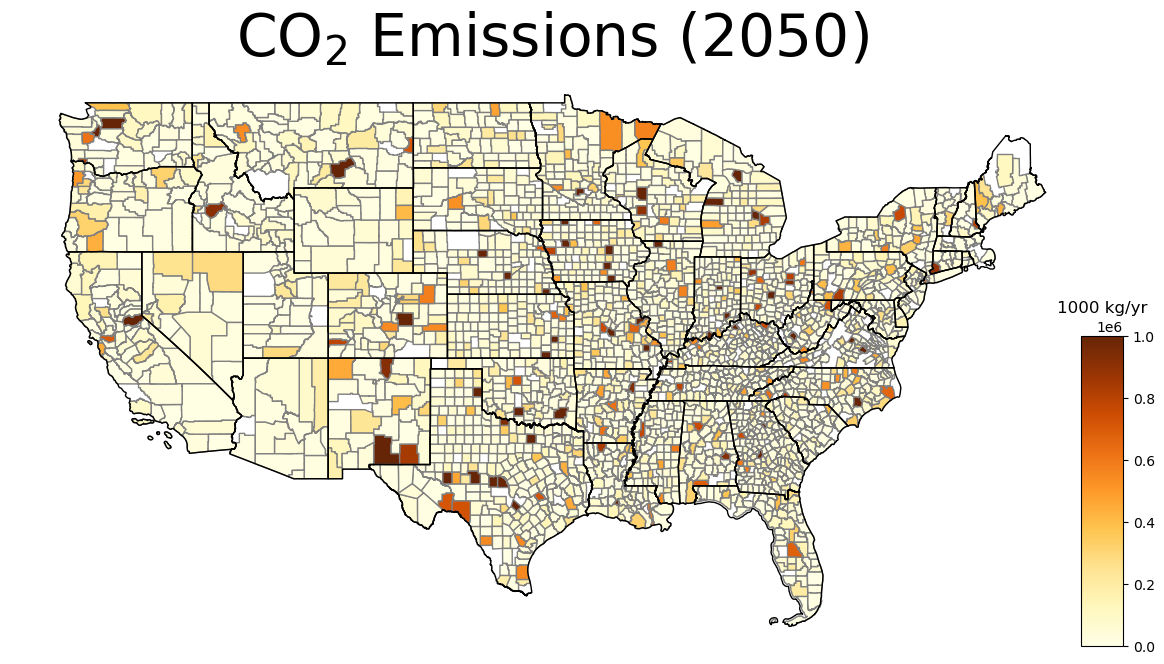

In [ ]:
# Plot emissions for 2050

geodf = gp.GeoDataFrame(emission_plot_df,crs="EPSG:4326", geometry=emission_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['emission_2050'].min(), geodf['emission_2050'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')


# Set title
ax.set_title(r'CO$_{2}$ Emissions (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
cbax.set_title('1000 kg/yr')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['emission_2050'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(0,1e6)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['emission_2050'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['emission_2050'],cmap=colormap,edgecolor='grey')


In [ ]:
# geodf[geodf['state_id']==50]
# geodf['difference %'].idxmax()
# geodf.iloc[2597]

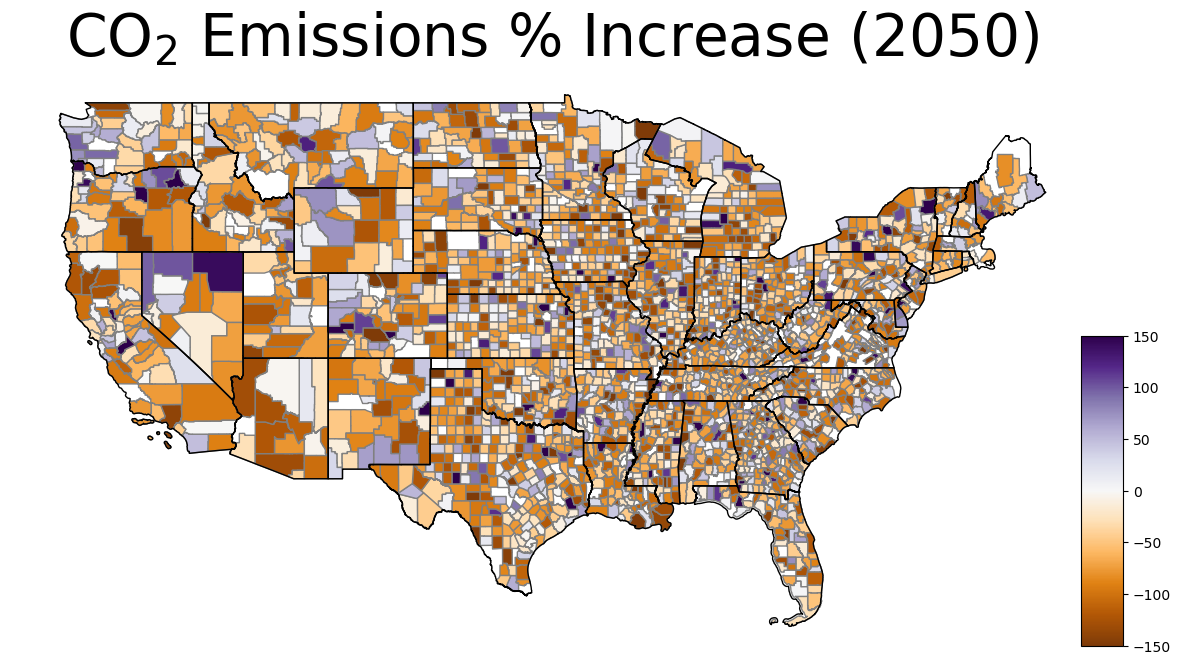

In [ ]:
# Plot % increase in emissions for 2050

geodf = gp.GeoDataFrame(emission_plot_df,crs="EPSG:4326", geometry=emission_plot_df['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['difference %'].min(), geodf['difference %'].max()
colormap = "PuOr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title(r'CO$_{2}$ Emissions % Increase (2050)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
# cbax.set_title('1000 kg/yr')

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['difference %'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(-150,150)

# # Plotting Alaska
# akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
# akax.axis('off')
# polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
# geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['difference %'],cmap=colormap,edgecolor='grey')

# # Plotting Hawaii
# hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
# hiax.axis('off')
# # polygon to clip western islands
# hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
# geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['difference %'],cmap=colormap,edgecolor='grey')

Rough work for analysis

In [ ]:
# treatment_df.head(2)
# pop_df.head(1)
# demand_present_df.head(1)
# us_counties.head(1)
# co2_df.head(1)

In [ ]:
# Using us counties and assigning treatment facilties (trying)
treatment_type_list = []

# Removing US territories
us_counties_temp = us_counties[(us_counties['STATEFP']!='78') & (us_counties['STATEFP']!='69') &
                            (us_counties['STATEFP']!='66') & (us_counties['STATEFP']!='60') & (us_counties['STATEFP']!='72')]

state_code_temp = state_code.set_index('state_id')

# Going state wise
for state_id in us_counties_temp['STATEFP'].unique():
    state = state_code_temp.loc[int(state_id)]['abbv']
    state_df = us_counties_temp[us_counties_temp['STATEFP']==state_id]
    # print(state)
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        county = row['NAME']
        # Check is county was correctly assigned in the facilities file
        treatment_df_temp = treatment_df[(treatment_df['state']==state) & (treatment_df['county']==county)]
        try:
            plant_type = treatment_df_temp['plant_type'].values[0]
            # print(county,plant_type)
        except:
            plant_type = 'SW'
        treatment_type_list.append(plant_type)

# treatment_loc = treatment_df.drop(index = idx_list)
# treatment_loc['state_id'] = state_id_list
# treatment_loc['county_id'] = county_id
# treatment_loc['geoid'] = geoid
# treatment_loc.head(3)


In [ ]:
# state_code_temp = state_code.set_index('abbv')

In [ ]:
us_counties_temp = us_counties.set_index('GEOID')
geometry_col = []
idx_list = []
for idx , row in demand_present_df.iterrows():
    geoid = str("{:05d}".format(row['geoid']))
    try:
        geometry_col.append(us_counties_temp.loc[geoid].geometry)
# for state in demand_present_df['state'].unique()[1:2]:
#     state_code = str("{:02d}".format(state_code_temp.loc[state]['FIPS']))
#     # print(state_code)
#     for idx , row in demand_present_df[demand_present_df['STATE']==state].iterrows():
#         county = row['COUNTY']
#         # print(county)
#         try:
#             # geometry_col.append(us_counties.loc[us_counties['GEOID']==geoid][['geometry']].values)
#             # geometry_col.append(us_counties.loc[us_counties['GEOID']==geoid,'geometry'])
#             geometry_col.append(us_counties_temp[us_counties_temp['STATEFP']==state_code].loc[county].geometry)
    except KeyError:
        pass
        idx_list.append(idx)
    except IndexError:
        pass
    except ValueError:
        pass

demand_present_loc = demand_present_df.drop(index=idx_list)
demand_present_loc['geometry'] = geometry_col
demand_present_loc.head(3)

state  state_id     county_name  county_id  geoid  pop_2015  \
0    AL         1  Autauga County          1   1001     55347   
1    AL         1  Baldwin County          3   1003    203709   
2    AL         1  Barbour County          5   1005     26489   

   2015_public_supply_total(MGD)  2015_domestic_supply_total(MGD)  \
0                           3.64                             3.09   
1                          23.67                            14.92   
2                           3.23                             1.54   

   2015_public_supply_total(m3/day)  2015_domestic_supply_total(m3/day)  \
0                        13778.8924                          11696.9169   
1                        89600.6547                          56478.3172   
2                        12226.8743                           5829.5314   

                                            geometry  
0  POLYGON ((-86.90309599999995 32.54062600000003...  
1  POLYGON ((-87.99068399999999 30.55549000000008...  
2  POLYGON ((-85.42981899999995 32.04598300000004...

In [ ]:
geodf_cont.tail(5)

state  state_id        county_name  county_id  geoid  pop_2015  \
3137    WY        56  Sweetwater County         37  56037     44626   
3138    WY        56       Teton County         39  56039     23125   
3139    WY        56       Uinta County         41  56041     20822   
3140    WY        56    Washakie County         43  56043      8328   
3141    WY        56      Weston County         45  56045      7234   

      2015_public_supply_total(MGD)  2015_domestic_supply_total(MGD)  \
3137                          11.37                             8.57   
3138                           7.78                             6.17   
3139                           3.90                             3.21   
3140                           0.09                             0.92   
3141                           1.02                             0.90   

      2015_public_supply_total(m3/day)  2015_domestic_supply_total(m3/day)  \
3137                        43040.1117                          32440.9637   
3138                        29450.4898                          23355.9797   
3139                        14763.0990                          12151.1661   
3140                          340.6869                           3482.5772   
3141                         3861.1182                           3406.8690   

                                               geometry  
3137  POLYGON ((-109.49666 42.26332, -109.49212 42.2...  
3138  POLYGON ((-111.04909 44.13237, -111.04909 44.1...  
3139  POLYGON ((-110.60679 40.99626, -110.60689 40.9...  
3140  POLYGON ((-107.63349 43.64634, -107.63352 43.6...  
3141  POLYGON ((-105.07913 43.81301, -105.07913 43.8...

<Axes: >

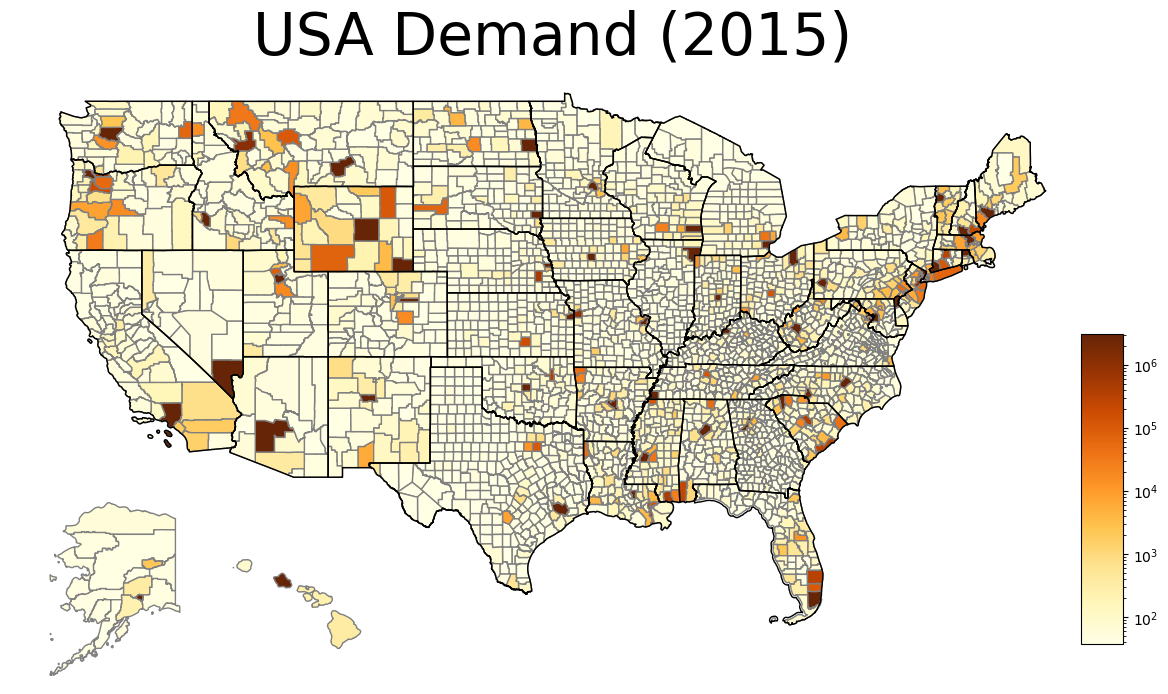

In [ ]:
# Plot water demand USA with Alaska and Hawaii for 2015

geodf = gp.GeoDataFrame(demand_present_loc,crs="EPSG:4326", geometry=demand_present_loc['geometry'])

geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15) & (geodf['state_id']!=72)& (geodf['state_id']!=78)]
# geodf_cont = geodf_cont[geodf_cont['state_id']==56]
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['2015_domestic_supply_total(m3/day)'].min(), geodf['2015_domestic_supply_total(m3/day)'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))

# Create figure
fig, ax = plt.subplots(figsize=(14,10))
ax.axis('off')

# Set title
ax.set_title('USA Demand (2015)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  

# Plotting contiguous states one at a time
for state in geodf_cont['state_id'].unique():
    geodf_cont_temp = geodf_cont[geodf_cont['state_id']==state]
    geodf_cont_temp.plot(ax=ax , column= geodf_cont_temp['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')
    
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)
sm.set_clim(1,1e7)

# Plotting Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

# Plotting Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['2015_domestic_supply_total(m3/day)'],cmap=colormap,edgecolor='grey')

In [ ]:
us_counties_temp = us_counties.set_index('GEOID')
geometry_col = []
for idx , row in pop_df.iterrows():
    geoid = str("{:05d}".format(row['geoid']))
    try:
        # geometry_col.append(us_counties.loc[us_counties['GEOID']==geoid][['geometry']].values)
        # geometry_col.append(us_counties.loc[us_counties['GEOID']==geoid,'geometry'])
        geometry_col.append(us_counties_temp.loc[geoid].geometry)
    except KeyError:
        print(idx)
    except IndexError:
        print(idx)
    except ValueError:
        print(idx)

pop_df_loc = pop_df.copy()
pop_df_loc['geometry'] = geometry_col

<Axes: >

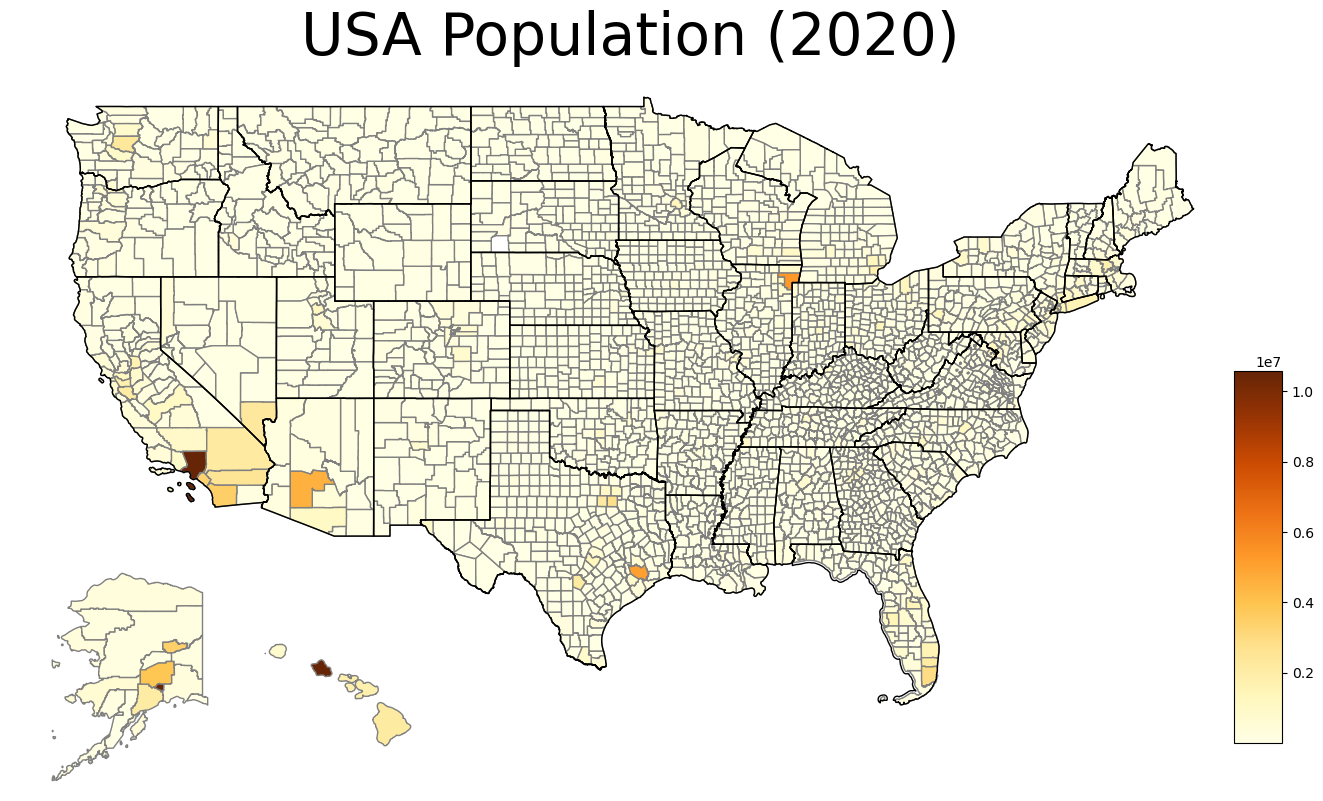

In [ ]:
# Plot population of USA with Alaska and Hawaii in 2015

geodf = gp.GeoDataFrame(pop_df_loc,crs="EPSG:4326", geometry=pop_df_loc['geometry'])
geodf_cont = geodf[(geodf['state_id']!=2) & (geodf['state_id']!=15)]
# Removing US territories
us_states_cont = us_states[(us_states['STATEFP']!='02') & (us_states['STATEFP']!='15') & 
                            (us_states['STATEFP']!='78') & (us_states['STATEFP']!='69') &
                            (us_states['STATEFP']!='66') & (us_states['STATEFP']!='60') & (us_states['STATEFP']!='72')]

# Creating scale for colorbar
vmin,vmax = geodf['ssp22020'].min(),geodf['ssp22020'].max()
colormap = "YlOrBr"
# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fig.colorbar(sm, cax=cbax)

# Create figure
fig, ax = plt.subplots(figsize=(16,12))
ax.axis('off')

# Set title
ax.set_title('USA Population (2020)',fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  

# Plotting contiguous states
geodf_cont.plot(ax=ax , column= geodf_cont['ssp22020'],cmap=colormap,edgecolor='grey')
us_states_cont.plot(ax = ax , edgecolor='black',facecolor='none')
fig.colorbar(sm, cax=cbax)

# Plotting Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])   
geodf.loc[geodf['state_id']==2].clip(polygon).plot(ax=akax, column = geodf.loc[geodf['state_id']==2].clip(polygon)['ssp22020'],cmap=colormap,edgecolor='grey')

# Plotting Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
geodf.loc[geodf['state_id']==15].clip(hipolygon).plot(ax=hiax, column = geodf.loc[geodf['state_id']==15].clip(hipolygon)['ssp22020'],cmap=colormap,edgecolor='grey')

In [ ]:
# # Function to calculate energy county level and then state level
# def plot_results(df):
#     # Aggregate on state level
#     state_list = []
#     energy_list = []
#     co2_list = []

#     for state in df.state.unique():
#         df_temp = df[df['state'] == state]
#         state_list.append(state)
#         energy_list.append(df_temp['total_energy(mwh/year)'].sum())
#         co2_list.append(df_temp['co2(kg/year)'].sum())
    
#     df_results = pd.DataFrame(zip(state_list,energy_list,co2_list),columns=['state','energy(mwh/year)','co2(kg/year)'])

#     fig,ax = plt.subplots(figsize=(10,8))

#     x =  np.array(range(0,len(df_results['state'])))*50
#     ax.bar(x,df_results['energy(mwh/year)']/1e6,width=25)

#     ax.set_xticks(x,df_results['state'],rotation = 90)
#     ax.set_ylim([0,0.06])
#     ax.set_ylabel('Energy (TWh/m3)')

#     clear_output(wait=True)
#     return df_results

# df_results = plot_results(analysis_results_2020)
# # df_results.head()

In [ ]:
# geodf.loc[geodf['state']==4].plot(column = geodf.loc[geodf['state']==4]['ssp22020'])

In [ ]:
# test = gp.GeoSeries(geometry_col)
# test.plot()

In [ ]:
# # Cleaning up treatment facilities files

# # Assign geoid number
# us_counties_temp = us_counties.set_index('NAMELSAD')
# state_code_temp = state_code.set_index('abbv')
# idx_list = []
# geoid = []
# state_id_list = []
# county_id = []

# for state in treatment_df['state'].unique():
#     try:
#         state_id = state_code_temp.loc[state]['state_id']
#         treatment_subdf = treatment_df[treatment_df['state']==state]
#         for idx, row in treatment_subdf.iterrows():
#             state_id_list.append(state_id)
#             state_id_str = str("{:02d}".format(state_id))
#             try:
#                 county = row['county'] + ' County'
#                 try:
#                     temp_df = us_counties_temp.loc[county][us_counties_temp['STATEFP']==state_id_str]
#                     geoid.append(int(temp_df['GEOID']))
#                     county_id.append(int(temp_df['COUNTYFP']))
#                 except KeyError:
#                     point = Point(row['longitude'],row['latitude'])
#                     for geo_idx, geo in us_counties_temp[us_counties_temp['STATEFP']==state_id_str].iterrows(): 
#                         polygon = geo.geometry
#                         if polygon.contains(point):
#                             # Assign county id and geoid
#                             county_index = geo_idx
#                             # print('correct_1',county,geo['GEOID'],geo_idx)
#                         # else:
#                             # geoid.append(0)
#                             # county_id.append(0)
#                     geoid.append(int(geo.loc[county_index]['GEOID']))
#                     county_id.append(int(geo.loc[county_index]['COUNTYFP']))
#             except TypeError:
#                 # These water treatment facilities do not have counties assigned
#                 # Iterate through the counties in the state and identify county name using the us_counties_df
#                 point = Point(row['longitude'],row['latitude'])
#                 for geo_idx, geo in us_counties_temp[us_counties_temp['STATEFP']==state_id_str].iterrows(): 
#                     polygon = geo.geometry
#                     if polygon.contains(point):
#                         # Assign county id and geoid
#                         county_index = geo_idx
#                 try:
#                     geoid.append(int(geo.loc[county_index]['GEOID']))
#                     county_id.append(int(geo.loc[county_index]['COUNTYFP']))
#                 except KeyError:
#                     pass
        
#     except ValueError:
#         treatment_subdf = treatment_df[treatment_df['state']==state]
#         for idx, row in treatment_subdf.iterrows():
#             idx_list.append(idx)
